# Shear Prediction

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [3]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import boxcox_normmax
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preparing the Data

In [4]:
pressure_ = pd.read_csv('pressure_planeA.csv')
pressure_

,% x,y,z,p (Pa) @ t=0.03,p (Pa) @ t=0.030001,p (Pa) @ t=0.030002,p (Pa) @ t=0.030002.1,p (Pa) @ t=0.030003,p (Pa) @ t=0.030004,p (Pa) @ t=0.030005,...,p (Pa) @ t=0.059957,p (Pa) @ t=0.059962,p (Pa) @ t=0.059967,p (Pa) @ t=0.059971,p (Pa) @ t=0.059976,p (Pa) @ t=0.059981,p (Pa) @ t=0.059986,p (Pa) @ t=0.059991,p (Pa) @ t=0.059995,p (Pa) @ t=0.059999
0,0.195517,-1.245862,1.808658,6078.379212,-2545.803098,4053.873359,-412.677908,2325.020326,864.811329,1716.386834,...,6744.009691,6740.353901,6738.354550,6738.610325,6742.151496,6742.405046,6742.480520,6736.614247,6737.529758,6740.765726
1,0.147438,-1.247513,1.809529,6079.292886,-2546.541550,4054.283399,-412.905406,2325.239957,864.678916,1716.464723,...,6743.945213,6740.289352,6738.290183,6738.546159,6742.087222,6742.340590,6742.416034,6736.549944,6737.465572,6740.701543
2,0.119787,-1.300000,1.806773,6085.034277,-2546.901647,4059.191077,-411.949056,2328.587589,866.646047,1718.874786,...,6746.352820,6742.697138,6740.697514,6740.953162,6744.494694,6744.748585,6744.824218,6738.957828,6739.872986,6743.109150
3,0.096268,-1.252510,1.808348,6080.225892,-2546.928532,4055.107751,-412.940614,2325.839953,864.796485,1716.776087,...,6744.123140,6740.467228,6738.468211,6738.724363,6742.265350,6742.518577,6742.594014,6736.728090,6737.643794,6740.879781
4,-0.055305,-1.300000,3.699022,6085.172785,-2524.891424,4061.323740,-391.420241,2333.249819,884.846514,1726.933061,...,6760.986947,6757.330838,6755.327102,6755.580034,6759.126352,6759.385842,6759.461114,6753.589010,6754.502896,6757.741500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8723,-0.169022,-1.221289,2.408197,6081.537861,-2533.174341,4058.024958,-400.103807,2330.874241,876.424745,1724.030347,...,6755.590348,6751.934640,6749.934470,6750.190107,6753.732616,6753.987286,6754.062843,6748.196083,6749.110988,6752.347715
8724,-0.197621,-1.178124,2.238170,6076.655586,-2534.155240,4053.602929,-402.114823,2327.711022,873.545500,1721.591898,...,6752.505819,6748.849929,6746.850992,6747.107442,6750.648762,6750.902180,6750.977729,6745.112071,6746.027689,6749.263984
8725,-0.185303,-1.221889,2.176616,6078.433318,-2535.892239,4054.704865,-403.251009,2328.110028,872.866815,1721.428162,...,6751.725339,6748.069532,6746.070534,6746.326874,6749.868196,6750.121688,6750.197332,6744.331626,6745.247122,6748.483384
8726,0.004867,-1.243101,2.277815,6080.321584,-2534.797901,4056.708390,-401.675962,2329.460564,874.873470,1722.606158,...,6753.635843,6749.980164,6747.979993,6748.235488,6751.777843,6752.032455,6752.108068,6746.241237,6747.156127,6750.392746


In [5]:
pressure = pressure_.filter(regex='p')

In [6]:
pressure_mean = pressure.mean(axis=0).to_frame().transpose()
pressure_mean

,p (Pa) @ t=0.03,p (Pa) @ t=0.030001,p (Pa) @ t=0.030002,p (Pa) @ t=0.030002.1,p (Pa) @ t=0.030003,p (Pa) @ t=0.030004,p (Pa) @ t=0.030005,p (Pa) @ t=0.030006,p (Pa) @ t=0.030008,p (Pa) @ t=0.030009,...,p (Pa) @ t=0.059957,p (Pa) @ t=0.059962,p (Pa) @ t=0.059967,p (Pa) @ t=0.059971,p (Pa) @ t=0.059976,p (Pa) @ t=0.059981,p (Pa) @ t=0.059986,p (Pa) @ t=0.059991,p (Pa) @ t=0.059995,p (Pa) @ t=0.059999
0,6069.302339,-2526.135781,4047.71596,-395.540179,2324.37144,878.128616,1720.894637,1571.000401,1720.155881,1862.413895,...,6755.352917,6751.696208,6749.696673,6749.952814,6753.495213,6753.749807,6753.824122,6747.956841,6748.873539,6752.110388


In [7]:
pressure_mean = pressure_mean.T
pressure_mean = pressure_mean.rename(columns={0: 'Pressure'})
pressure_mean.reset_index(drop=True, inplace=True)
pressure_mean = pressure_mean.drop(index=pressure_mean.index[-2:])
pressure_mean

,Pressure
0,6069.302339
1,-2526.135781
2,4047.715960
3,-395.540179
4,2324.371440
...,...
8444,6749.952814
8445,6753.495213
8446,6753.749807
8447,6753.824122


## Detrending Data

In [8]:
def detrend_and_plot(pressure_probe, window_size=6):
    # Detrend the data using a rolling mean
    rolling_mean = pressure_probe.rolling(window_size).mean()
    detrended = pressure_probe - rolling_mean
    
    # Plot the detrended series and its autocorrelation and partial autocorrelation
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))
    detrended.plot(ax=ax1)
    ax1.set_title('Detrended Pressure Probe Data')
    plot_acf(detrended, ax=ax2)
    ax2.set_title('Autocorrelation Function')
    plot_pacf(detrended, ax=ax3)
    ax3.set_title('Partial Autocorrelation Function')
    plt.tight_layout()
    plt.show()
    
    # Use the PACF plot to identify the most correlated components
    pacf_vals = pd.Series(np.abs(detrended.dropna().autocorr(lag=1)))
    for i in range(1, 30):
        pacf_vals[i] = np.abs(detrended.dropna().autocorr(lag=i+1) -
                              detrended.dropna().autocorr(lag=i))
    pacf_vals = pacf_vals.dropna()
    max_vals = pacf_vals.sort_values(ascending=False)[:3].index.tolist()
    
    # Use a sliding window to create a dataframe with the most correlated components
    df = pd.DataFrame()
    for i in max_vals:
        col = detrended.shift(i).dropna().reset_index(drop=True)
        df = pd.concat([df, col], axis=1)
    df.columns = ['Component {}'.format(i) for i in range(1, len(max_vals)+1)]
    
    return df

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


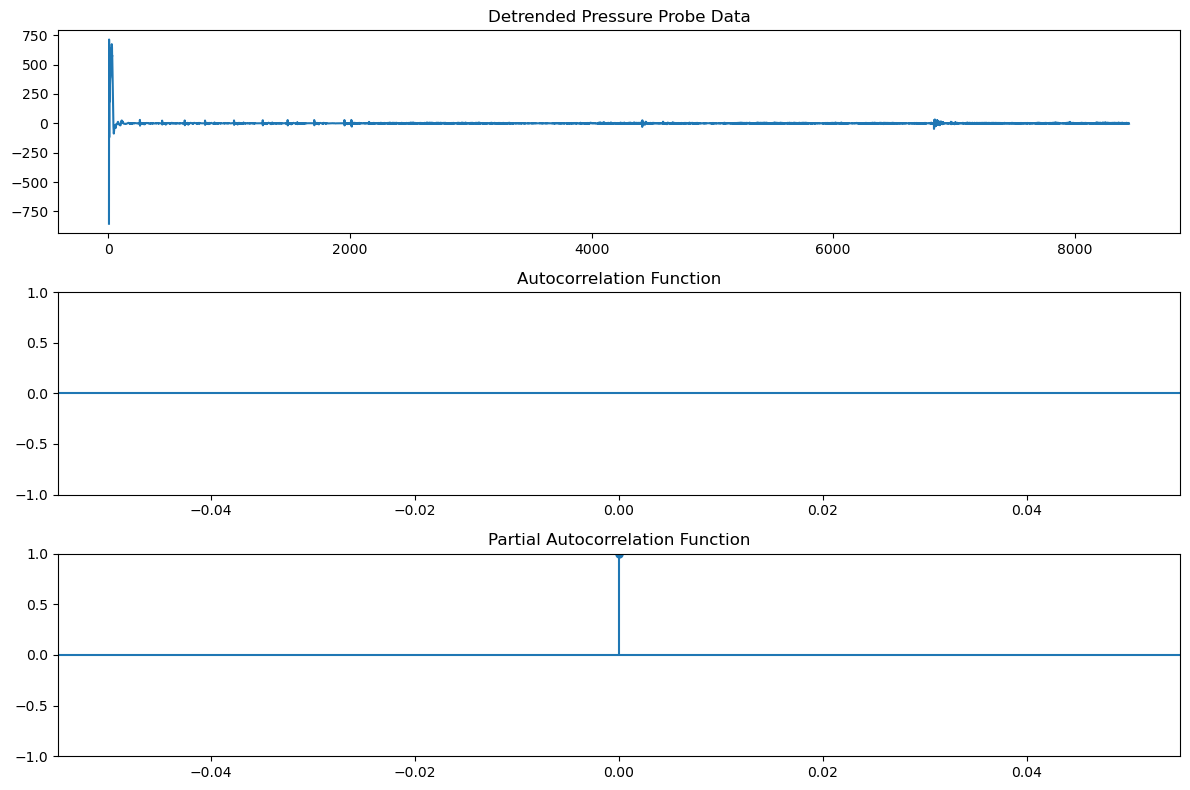

In [9]:
pressure_mean2 = detrend_and_plot(pressure_mean['Pressure'])

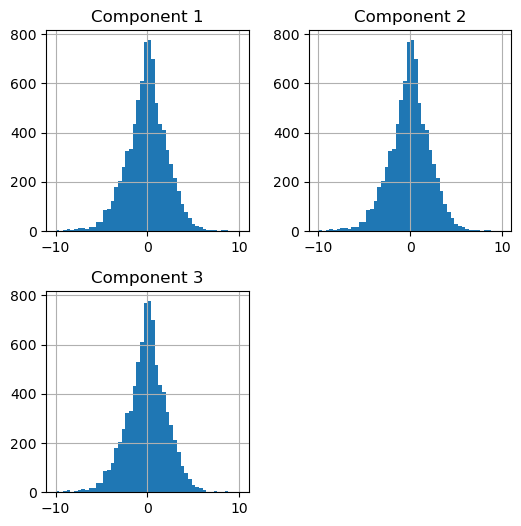

In [10]:
pressure_mean2.hist(bins=50, range=(-10, 10), figsize=(6,6))
plt.show()

In [11]:
pressure_mean2.describe()

,Component 1,Component 2,Component 3
count,8444.000000,8443.000000,8415.000000
mean,1.541003,1.541599,1.546970
std,31.782420,31.784256,31.836668
min,-854.845117,-854.845117,-854.845117
25%,-1.340232,-1.339671,-1.336198
50%,0.018189,0.018571,0.018686
75%,1.324028,1.324150,1.320886
max,712.655522,712.655522,712.655522


In [12]:
shear = pd.read_csv('shear_full.csv')
shear = shear.filter(regex='spf.sr')
shear

,spf.sr*spf.mu (N/m^2) @ t=0.03,spf.sr*spf.mu (N/m^2) @ t=0.030001,spf.sr*spf.mu (N/m^2) @ t=0.030002,spf.sr*spf.mu (N/m^2) @ t=0.030002.1,spf.sr*spf.mu (N/m^2) @ t=0.030003,spf.sr*spf.mu (N/m^2) @ t=0.030004,spf.sr*spf.mu (N/m^2) @ t=0.030005,spf.sr*spf.mu (N/m^2) @ t=0.030006,spf.sr*spf.mu (N/m^2) @ t=0.030008,spf.sr*spf.mu (N/m^2) @ t=0.030009,...,spf.sr*spf.mu (N/m^2) @ t=0.059957,spf.sr*spf.mu (N/m^2) @ t=0.059962,spf.sr*spf.mu (N/m^2) @ t=0.059967,spf.sr*spf.mu (N/m^2) @ t=0.059971,spf.sr*spf.mu (N/m^2) @ t=0.059976,spf.sr*spf.mu (N/m^2) @ t=0.059981,spf.sr*spf.mu (N/m^2) @ t=0.059986,spf.sr*spf.mu (N/m^2) @ t=0.059991,spf.sr*spf.mu (N/m^2) @ t=0.059995,spf.sr*spf.mu (N/m^2) @ t=0.059999
0,0.001661,0.001229,0.001347,0.001359,0.001173,0.001127,0.000941,0.000841,0.000769,0.000339,...,0.712288,0.769181,0.825011,0.874087,0.911370,0.935233,0.949621,0.964433,0.987947,1.017550
1,0.000600,0.000559,0.000420,0.000432,0.000442,0.000487,0.000483,0.000402,0.000588,0.000592,...,0.599688,0.647709,0.698117,0.748478,0.795594,0.836041,0.867479,0.890477,0.905834,0.915337
2,0.001614,0.001227,0.001385,0.001354,0.001138,0.001058,0.000863,0.000725,0.000667,0.000520,...,0.695514,0.752382,0.804599,0.849480,0.886820,0.919383,0.952536,0.993755,1.046884,1.097841
3,0.003579,0.002817,0.002402,0.002321,0.002114,0.001994,0.001551,0.001034,0.001021,0.000748,...,0.871406,0.946044,1.012509,1.074405,1.141118,1.222709,1.326372,1.451565,1.588804,1.692537
4,0.003834,0.002958,0.002692,0.002624,0.002328,0.002168,0.001685,0.001192,0.001046,0.000403,...,0.889106,0.947841,0.997763,1.039449,1.080224,1.131351,1.203601,1.300882,1.415846,1.508604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2613,44.692977,16.892111,4.122483,8.952320,19.446119,28.769585,42.252884,49.913482,50.651641,47.087968,...,1.162288,1.176940,1.190905,1.205292,1.221126,1.238031,1.255170,1.271646,1.287597,1.300253
2614,62.081244,7.367255,30.377147,41.862783,48.365785,51.704257,52.304593,49.475741,43.078709,35.020611,...,1.129347,1.139505,1.154172,1.172893,1.195166,1.220706,1.249647,1.281470,1.315593,1.341940
2615,60.970157,12.071255,33.590700,44.521861,51.063726,53.813493,51.903402,46.851414,40.518380,34.036842,...,1.631634,1.644138,1.659543,1.676747,1.695045,1.714472,1.735654,1.758450,1.782274,1.799843
2616,45.916776,11.778041,6.154845,17.631410,28.119880,37.180190,48.708462,53.657610,52.324056,47.668082,...,1.123661,1.149738,1.175337,1.201491,1.228904,1.257009,1.285000,1.311914,1.337881,1.357508


In [13]:
shear_mean = shear.mean(axis=0).to_frame().transpose()
shear_mean

,spf.sr*spf.mu (N/m^2) @ t=0.03,spf.sr*spf.mu (N/m^2) @ t=0.030001,spf.sr*spf.mu (N/m^2) @ t=0.030002,spf.sr*spf.mu (N/m^2) @ t=0.030002.1,spf.sr*spf.mu (N/m^2) @ t=0.030003,spf.sr*spf.mu (N/m^2) @ t=0.030004,spf.sr*spf.mu (N/m^2) @ t=0.030005,spf.sr*spf.mu (N/m^2) @ t=0.030006,spf.sr*spf.mu (N/m^2) @ t=0.030008,spf.sr*spf.mu (N/m^2) @ t=0.030009,...,spf.sr*spf.mu (N/m^2) @ t=0.059957,spf.sr*spf.mu (N/m^2) @ t=0.059962,spf.sr*spf.mu (N/m^2) @ t=0.059967,spf.sr*spf.mu (N/m^2) @ t=0.059971,spf.sr*spf.mu (N/m^2) @ t=0.059976,spf.sr*spf.mu (N/m^2) @ t=0.059981,spf.sr*spf.mu (N/m^2) @ t=0.059986,spf.sr*spf.mu (N/m^2) @ t=0.059991,spf.sr*spf.mu (N/m^2) @ t=0.059995,spf.sr*spf.mu (N/m^2) @ t=0.059999
0,13.160372,5.835691,5.222648,5.311757,5.547779,5.98176,6.961887,7.923015,8.507727,8.671579,...,1.103411,1.110017,1.116104,1.121608,1.126377,1.130117,1.132788,1.134512,1.13522,1.134927


In [14]:
shear_mean = shear_mean.T
shear_mean = shear_mean.rename(columns={0: 'Shear'})
shear_mean.reset_index(drop=True, inplace=True)
shear_mean = shear_mean.iloc[10:]
shear_mean = shear_mean.reset_index(drop=True)
shear_mean

,Shear
0,8.441785
1,8.010158
2,7.469516
3,6.877917
4,6.261286
...,...
8436,1.130117
8437,1.132788
8438,1.134512
8439,1.135220


C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


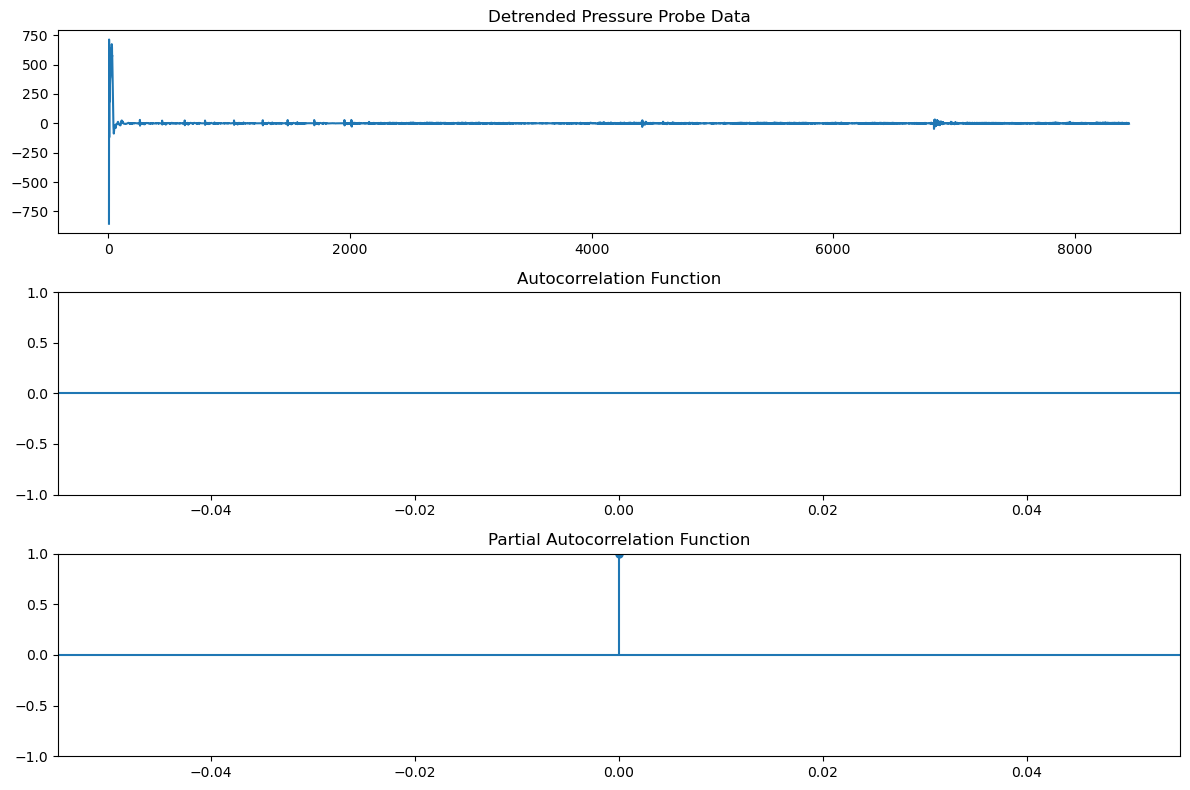

In [15]:
# detrend the pressure data and extract the three most correlated components
df = detrend_and_plot(pressure_mean['Pressure'])
df = df.join(shear_mean)

# use a sliding window to create a feature matrix with 10 previous time steps and 3 most correlated components
X = []
for i in range(10, len(df)):
    row = []
    for j in range(10, 0, -1):
        row.extend(df.iloc[i-j, :])
    X.append(row)
X = np.array(X)
X_df = pd.DataFrame(X, columns=[f'X_{i}' for i in range(X.shape[1])])

# create target vector
y = np.array(df['Shear'][10:]).reshape(-1, 1)
y_df = pd.DataFrame(y, columns=['Shear'])

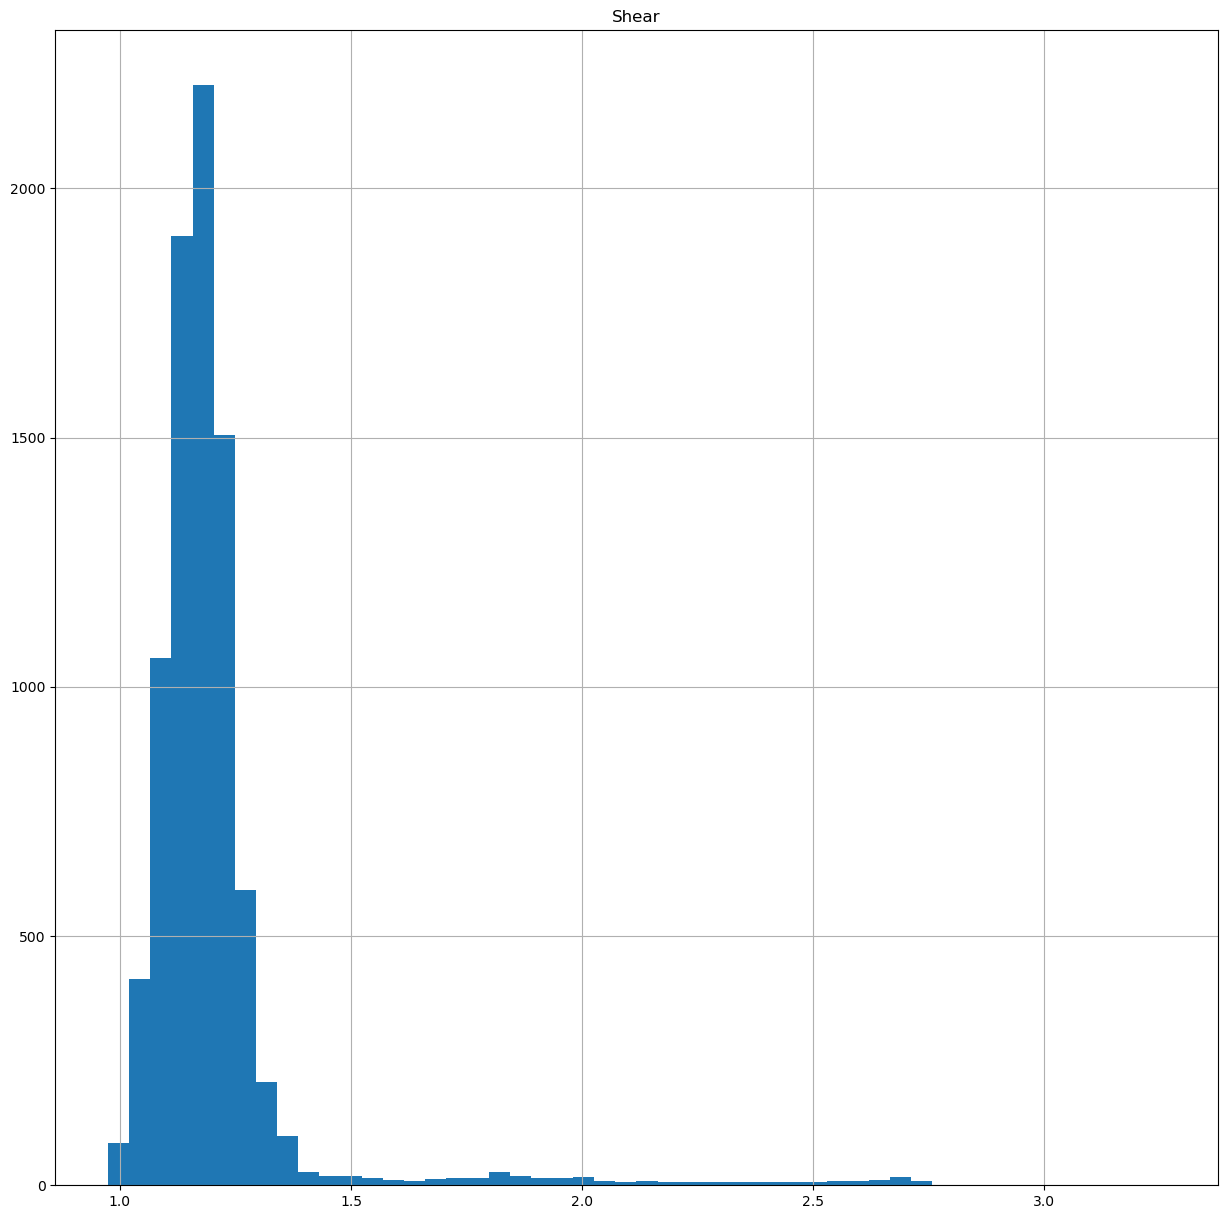

In [16]:
y_df.hist(bins=50, figsize=(15,15))
plt.show()

In [17]:
df = X_df
df = df.join(y_df)
df

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,Shear
0,-854.845117,-854.845117,-854.845117,8.441785,712.655522,712.655522,712.655522,8.010158,-120.094745,-120.094745,...,4.513571,326.742847,326.742847,326.742847,4.041164,361.558079,361.558079,361.558079,3.625554,3.261206
1,712.655522,712.655522,712.655522,8.010158,-120.094745,-120.094745,-120.094745,7.469516,416.987415,416.987415,...,4.041164,361.558079,361.558079,361.558079,3.625554,378.767125,378.767125,378.767125,3.261206,2.940547
2,-120.094745,-120.094745,-120.094745,7.469516,416.987415,416.987415,416.987415,6.877917,182.919750,182.919750,...,3.625554,378.767125,378.767125,378.767125,3.261206,385.894968,385.894968,385.894968,2.940547,2.660163
3,416.987415,416.987415,416.987415,6.877917,182.919750,182.919750,182.919750,6.261286,325.717821,325.717821,...,3.261206,385.894968,385.894968,385.894968,2.940547,393.335217,393.335217,393.335217,2.660163,2.425439
4,182.919750,182.919750,182.919750,6.261286,325.717821,325.717821,325.717821,5.638524,275.074773,275.074773,...,2.940547,393.335217,393.335217,393.335217,2.660163,414.620939,414.620939,414.620939,2.425439,2.223052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8429,-2.113495,-2.113495,NaN,1.088924,2.294601,2.294601,NaN,1.096347,2.088261,2.088261,...,1.130117,-0.372862,-0.372862,NaN,1.132788,-2.287643,-2.287643,NaN,1.134512,1.135220
8430,2.294601,2.294601,NaN,1.096347,2.088261,2.088261,NaN,1.103411,-1.534857,-1.534857,...,1.132788,-2.287643,-2.287643,NaN,1.134512,-2.010913,-2.010913,NaN,1.135220,1.134927
8431,2.088261,2.088261,NaN,1.103411,-1.534857,-1.534857,NaN,1.110017,-1.561291,-1.561291,...,1.134512,-2.010913,-2.010913,NaN,1.135220,0.892842,0.892842,NaN,1.134927,NaN
8432,-1.534857,-1.534857,NaN,1.110017,-1.561291,-1.561291,NaN,1.116104,-1.950588,-1.950588,...,1.135220,0.892842,0.892842,NaN,1.134927,1.425868,1.425868,NaN,NaN,NaN


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8434 entries, 0 to 8433
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X_0     8434 non-null   float64
 1   X_1     8434 non-null   float64
 2   X_2     8415 non-null   float64
 3   X_3     8434 non-null   float64
 4   X_4     8434 non-null   float64
 5   X_5     8434 non-null   float64
 6   X_6     8414 non-null   float64
 7   X_7     8434 non-null   float64
 8   X_8     8434 non-null   float64
 9   X_9     8434 non-null   float64
 10  X_10    8413 non-null   float64
 11  X_11    8434 non-null   float64
 12  X_12    8434 non-null   float64
 13  X_13    8434 non-null   float64
 14  X_14    8412 non-null   float64
 15  X_15    8434 non-null   float64
 16  X_16    8434 non-null   float64
 17  X_17    8434 non-null   float64
 18  X_18    8411 non-null   float64
 19  X_19    8434 non-null   float64
 20  X_20    8434 non-null   float64
 21  X_21    8434 non-null   float64
 22  

In [19]:
df.describe()

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,Shear
count,8434.000000,8434.000000,8415.000000,8434.000000,8434.000000,8434.000000,8414.000000,8434.000000,8434.000000,8434.000000,...,8434.000000,8434.000000,8434.000000,8407.000000,8433.000000,8434.000000,8434.000000,8406.000000,8432.000000,8431.000000
mean,1.542868,1.542868,1.546970,1.208766,1.643993,1.643993,1.648752,1.207898,1.559841,1.559841,...,1.204042,1.394086,1.394086,1.399014,1.203650,1.355553,1.355553,1.360310,1.203313,1.203026
std,31.801124,31.801124,31.836668,0.260716,30.402875,30.402875,30.438595,0.248534,29.400347,29.400347,...,0.201748,28.373297,28.373297,28.418374,0.198514,28.151206,28.151206,28.197607,0.196106,0.194335
min,-854.845117,-854.845117,-854.845117,0.974213,-120.094745,-120.094745,-120.094745,0.974213,-120.094745,-120.094745,...,0.974213,-87.478646,-87.478646,-87.478646,0.974213,-87.478646,-87.478646,-87.478646,0.974213,0.974213
25%,-1.339244,-1.339244,-1.336198,1.123562,-1.339244,-1.339244,-1.335996,1.123528,-1.339244,-1.339244,...,1.123528,-1.339786,-1.339786,-1.336198,1.123517,-1.339786,-1.339786,-1.336259,1.123513,1.123508
50%,0.018189,0.018189,0.018686,1.173125,0.018189,0.018189,0.018974,1.173113,0.018189,0.018189,...,1.172999,0.017393,0.017393,0.017807,1.172994,0.017393,0.017393,0.017696,1.172968,1.172943
75%,1.323435,1.323435,1.320886,1.220595,1.323435,1.323435,1.321234,1.220585,1.323435,1.323435,...,1.220394,1.320030,1.320030,1.314943,1.220384,1.320030,1.320030,1.314361,1.220384,1.220380
max,712.655522,712.655522,712.655522,8.441785,712.655522,712.655522,712.655522,8.010158,673.281145,673.281145,...,4.513571,673.281145,673.281145,673.281145,4.041164,673.281145,673.281145,673.281145,3.625554,3.261206


In [20]:
df.median()

X_0      0.018189
X_1      0.018189
X_2      0.018686
X_3      1.173125
X_4      0.018189
X_5      0.018189
X_6      0.018974
X_7      1.173113
X_8      0.018189
X_9      0.018189
X_10     0.018686
X_11     1.173094
X_12     0.018629
X_13     0.018629
X_14     0.018974
X_15     1.173083
X_16     0.018189
X_17     0.018189
X_18     0.018686
X_19     1.173074
X_20     0.017696
X_21     0.017696
X_22     0.018629
X_23     1.173065
X_24     0.017393
X_25     0.017393
X_26     0.018571
X_27     1.173033
X_28     0.017393
X_29     0.017393
X_30     0.018189
X_31     1.172999
X_32     0.017393
X_33     0.017393
X_34     0.017807
X_35     1.172994
X_36     0.017393
X_37     0.017393
X_38     0.017696
X_39     1.172968
Shear    1.172943
dtype: float64

In [21]:
df.mean()

X_0      1.542868
X_1      1.542868
X_2      1.546970
X_3      1.208766
X_4      1.643993
X_5      1.643993
X_6      1.648752
X_7      1.207898
X_8      1.559841
X_9      1.559841
X_10     1.564239
X_11     1.207081
X_12     1.574414
X_13     1.574414
X_14     1.578701
X_15     1.206330
X_16     1.524928
X_17     1.524928
X_18     1.529313
X_19     1.205649
X_20     1.502969
X_21     1.502969
X_22     1.507744
X_23     1.205041
X_24     1.464110
X_25     1.464110
X_26     1.469189
X_27     1.204507
X_28     1.431601
X_29     1.431601
X_30     1.436648
X_31     1.204042
X_32     1.394086
X_33     1.394086
X_34     1.399014
X_35     1.203650
X_36     1.355553
X_37     1.355553
X_38     1.360310
X_39     1.203313
Shear    1.203026
dtype: float64

In [22]:
df.min()

X_0     -854.845117
X_1     -854.845117
X_2     -854.845117
X_3        0.974213
X_4     -120.094745
X_5     -120.094745
X_6     -120.094745
X_7        0.974213
X_8     -120.094745
X_9     -120.094745
X_10    -120.094745
X_11       0.974213
X_12     -87.478646
X_13     -87.478646
X_14     -87.478646
X_15       0.974213
X_16     -87.478646
X_17     -87.478646
X_18     -87.478646
X_19       0.974213
X_20     -87.478646
X_21     -87.478646
X_22     -87.478646
X_23       0.974213
X_24     -87.478646
X_25     -87.478646
X_26     -87.478646
X_27       0.974213
X_28     -87.478646
X_29     -87.478646
X_30     -87.478646
X_31       0.974213
X_32     -87.478646
X_33     -87.478646
X_34     -87.478646
X_35       0.974213
X_36     -87.478646
X_37     -87.478646
X_38     -87.478646
X_39       0.974213
Shear      0.974213
dtype: float64

In [23]:
df.max()

X_0      712.655522
X_1      712.655522
X_2      712.655522
X_3        8.441785
X_4      712.655522
X_5      712.655522
X_6      712.655522
X_7        8.010158
X_8      673.281145
X_9      673.281145
X_10     673.281145
X_11       7.469516
X_12     673.281145
X_13     673.281145
X_14     673.281145
X_15       6.877917
X_16     673.281145
X_17     673.281145
X_18     673.281145
X_19       6.261286
X_20     673.281145
X_21     673.281145
X_22     673.281145
X_23       5.638524
X_24     673.281145
X_25     673.281145
X_26     673.281145
X_27       5.051283
X_28     673.281145
X_29     673.281145
X_30     673.281145
X_31       4.513571
X_32     673.281145
X_33     673.281145
X_34     673.281145
X_35       4.041164
X_36     673.281145
X_37     673.281145
X_38     673.281145
X_39       3.625554
Shear      3.261206
dtype: float64

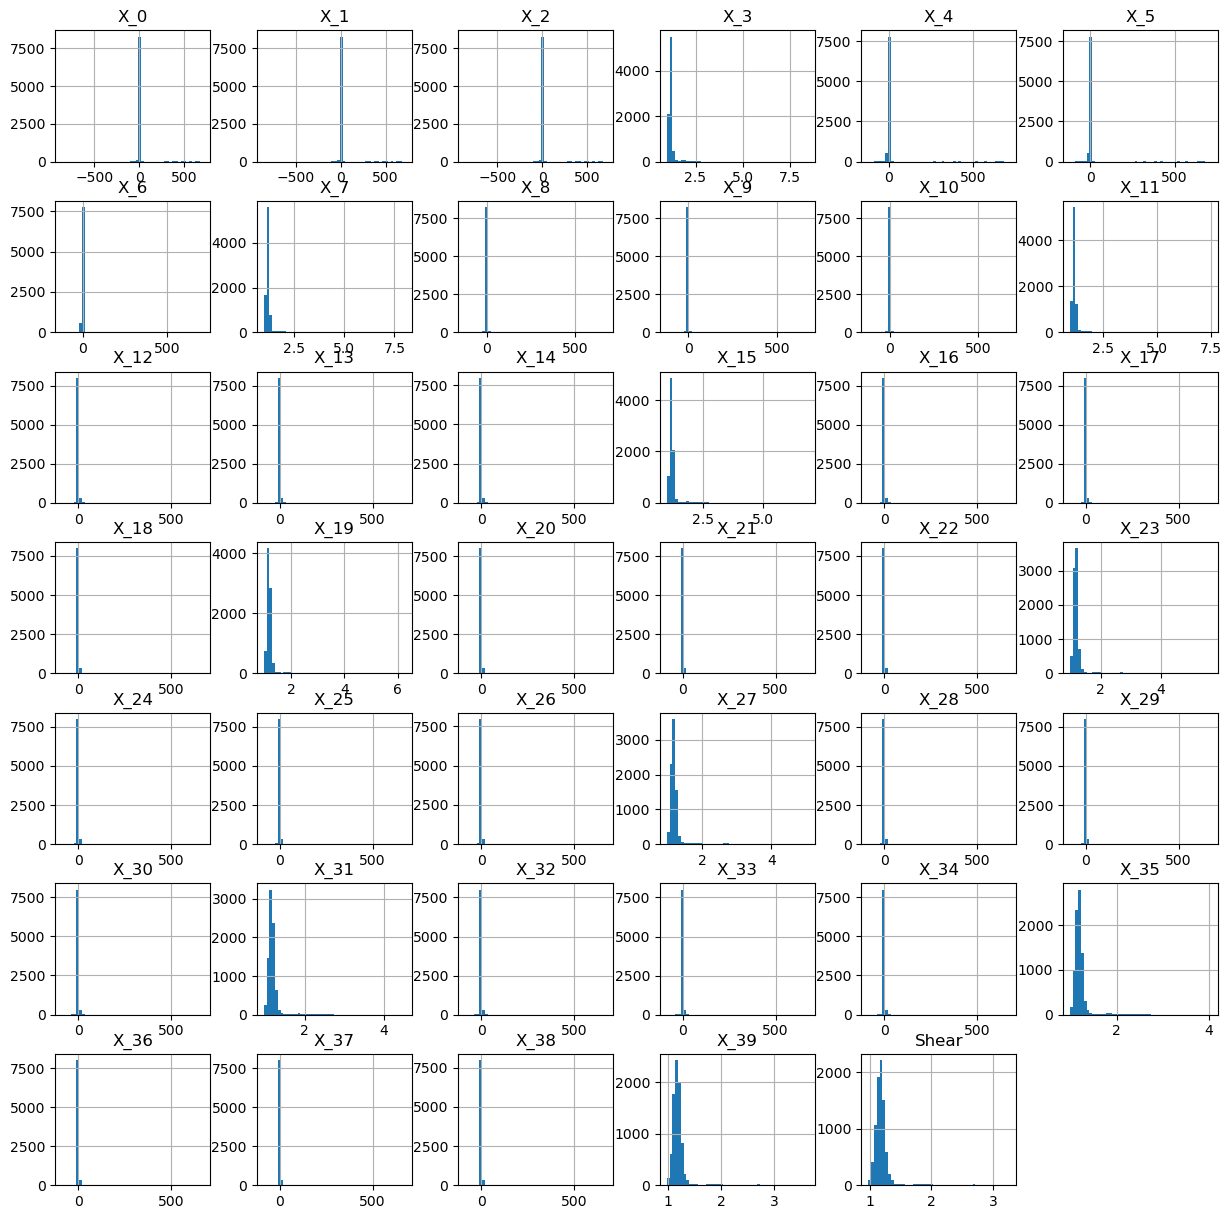

In [24]:
df.hist(bins=50, figsize=(15,15))
plt.savefig('detrend_hist.png')
plt.show()

# Correlations in Pressure Signals

## Pearson Correlation, Auto Correlation Function and Partial Autocorrelation Function

In [25]:
X = X_df
y = y_df

[Text(1, 0, 'X_0'),
 Text(2, 0, 'X_1'),
 Text(3, 0, 'X_2'),
 Text(4, 0, 'X_3'),
 Text(5, 0, 'X_4'),
 Text(6, 0, 'X_5'),
 Text(7, 0, 'X_6'),
 Text(8, 0, 'X_7'),
 Text(9, 0, 'X_8'),
 Text(10, 0, 'X_9'),
 Text(11, 0, 'X_10'),
 Text(12, 0, 'X_11'),
 Text(13, 0, 'X_12'),
 Text(14, 0, 'X_13'),
 Text(15, 0, 'X_14'),
 Text(16, 0, 'X_15'),
 Text(17, 0, 'X_16'),
 Text(18, 0, 'X_17'),
 Text(19, 0, 'X_18'),
 Text(20, 0, 'X_19'),
 Text(21, 0, 'X_20'),
 Text(22, 0, 'X_21'),
 Text(23, 0, 'X_22'),
 Text(24, 0, 'X_23'),
 Text(25, 0, 'X_24'),
 Text(26, 0, 'X_25'),
 Text(27, 0, 'X_26'),
 Text(28, 0, 'X_27'),
 Text(29, 0, 'X_28'),
 Text(30, 0, 'X_29'),
 Text(31, 0, 'X_30'),
 Text(32, 0, 'X_31'),
 Text(33, 0, 'X_32'),
 Text(34, 0, 'X_33'),
 Text(35, 0, 'X_34'),
 Text(36, 0, 'X_35'),
 Text(37, 0, 'X_36'),
 Text(38, 0, 'X_37'),
 Text(39, 0, 'X_38'),
 Text(40, 0, 'X_39')]

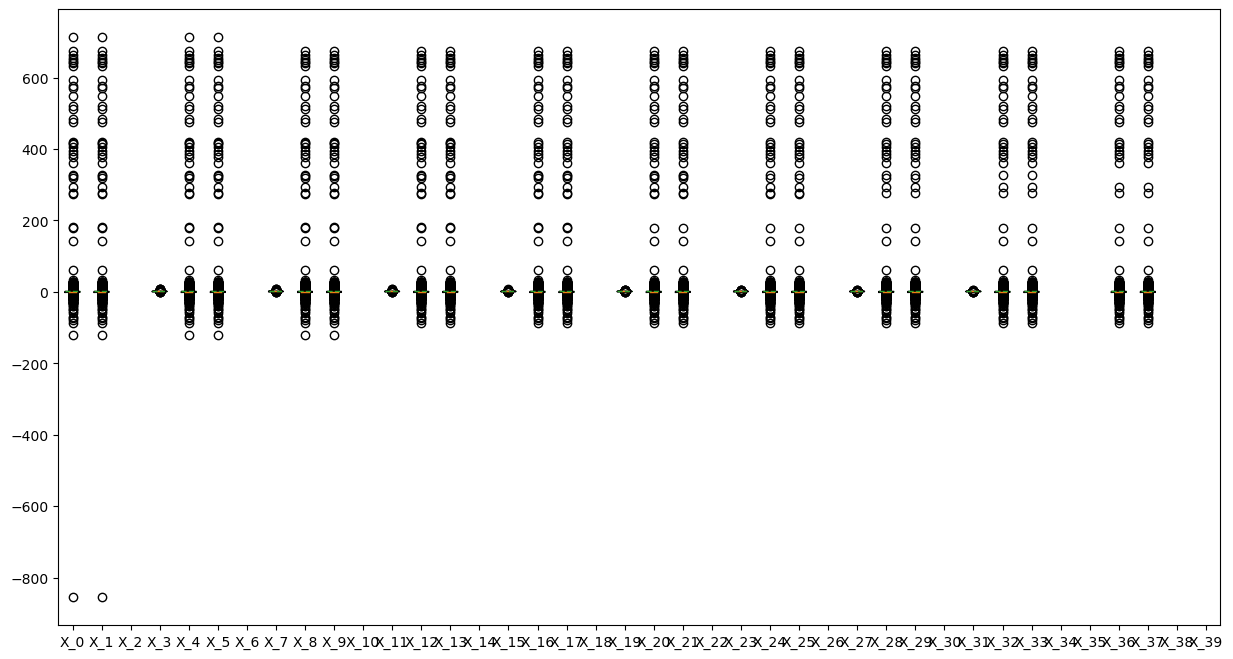

In [26]:
# Create a figure instance
fig = plt.figure(1, figsize=(15, 8))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(X, notch = True, meanline = True, showmeans = True)

# Save the figure
fig.savefig('fig1.png', bbox_inches='tight')

## Custom x-axis labels
ax.set_xticklabels(X.columns)

In [27]:
# Select first 4 columns
cols_to_compare = df.columns[0:39]

# Compute correlations using various methods
pearson_corr = df[cols_to_compare].corr(method='pearson')
spearman_corr = df[cols_to_compare].corr(method='spearman')
kendall_corr = df[cols_to_compare].corr(method='kendall')

# Display results
print('Pearson correlation:\n', pearson_corr)
print('Spearman correlation:\n', spearman_corr)
print('Kendall correlation:\n', kendall_corr)

Pearson correlation:
            X_0       X_1       X_2       X_3       X_4       X_5       X_6  \
X_0   1.000000  1.000000  1.000000  0.211137  0.772459  0.772459  0.772466   
X_1   1.000000  1.000000  1.000000  0.211137  0.772459  0.772459  0.772466   
X_2   1.000000  1.000000  1.000000  0.211137  0.772466  0.772466  0.772466   
X_3   0.211137  0.211137  0.211137  1.000000  0.345585  0.345585  0.345618   
X_4   0.772459  0.772459  0.772466  0.345585  1.000000  1.000000  1.000000   
X_5   0.772459  0.772459  0.772466  0.345585  1.000000  1.000000  1.000000   
X_6   0.772466  0.772466  0.772466  0.345618  1.000000  1.000000  1.000000   
X_7   0.197723  0.197723  0.197720  0.998178  0.328898  0.328898  0.328930   
X_8   0.934316  0.934316  0.934340  0.310436  0.916324  0.916324  0.916337   
X_9   0.934316  0.934316  0.934340  0.310436  0.916324  0.916324  0.916337   
X_10  0.934340  0.934340  0.934340  0.310464  0.916337  0.916337  0.916337   
X_11  0.187114  0.187114  0.187108  0.9924

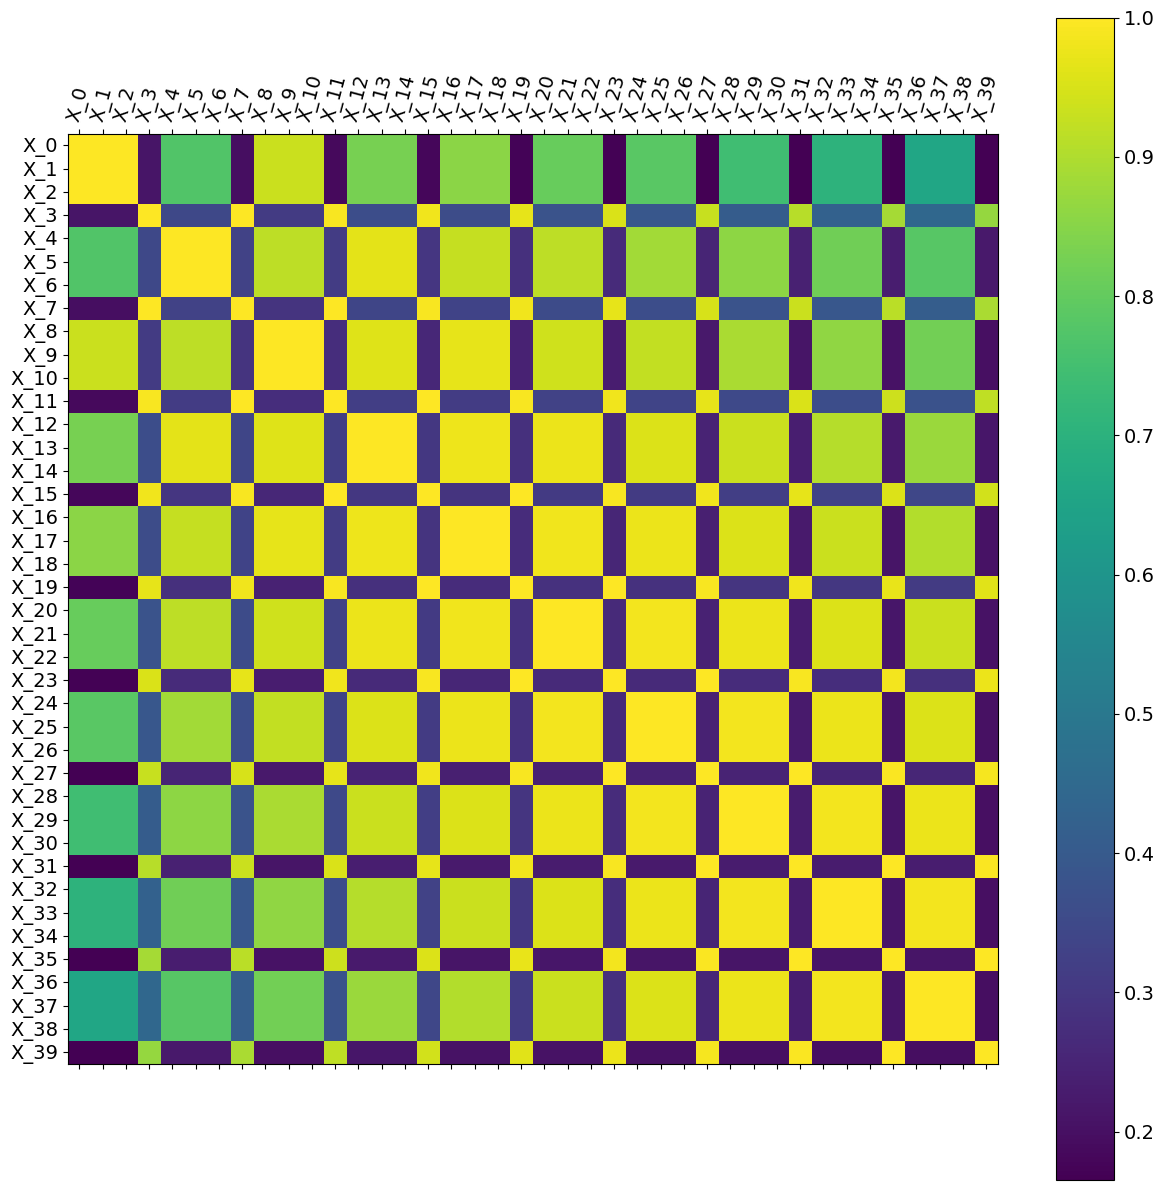

In [28]:
correlationMatrix = X.corr() 

f = plt.figure(figsize=(15, 15))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(X.shape[1]), X.columns, fontsize=14, rotation=75)
plt.yticks(range(X.shape[1]), X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

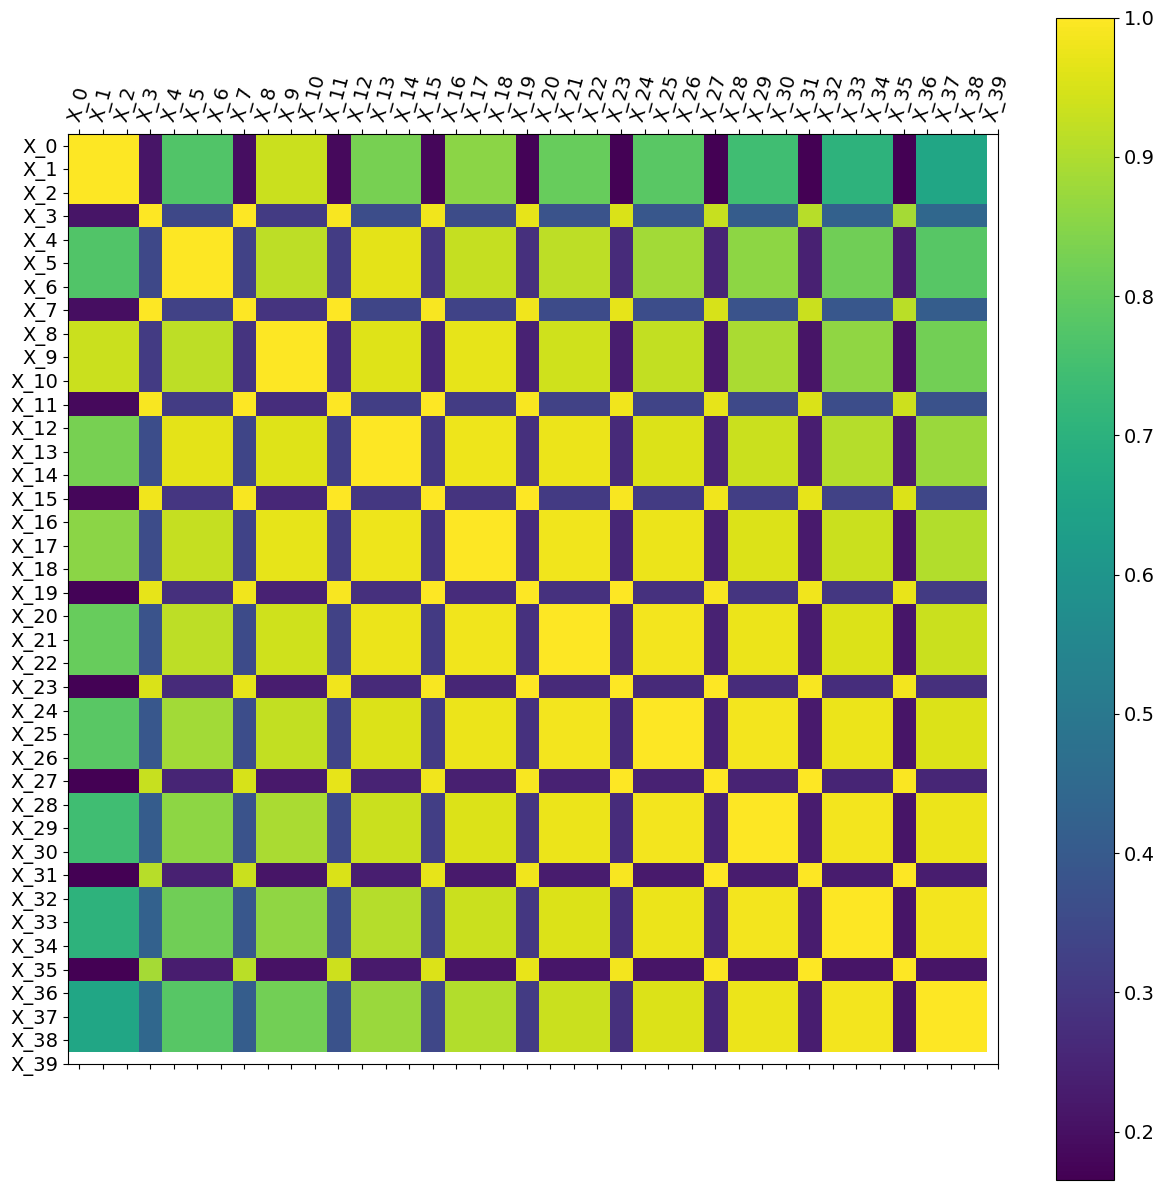

In [29]:
f = plt.figure(figsize=(15, 15))
plt.matshow(pearson_corr, fignum=f.number)
plt.xticks(range(X.shape[1]), X.columns, fontsize=14, rotation=75)
plt.yticks(range(X.shape[1]), X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

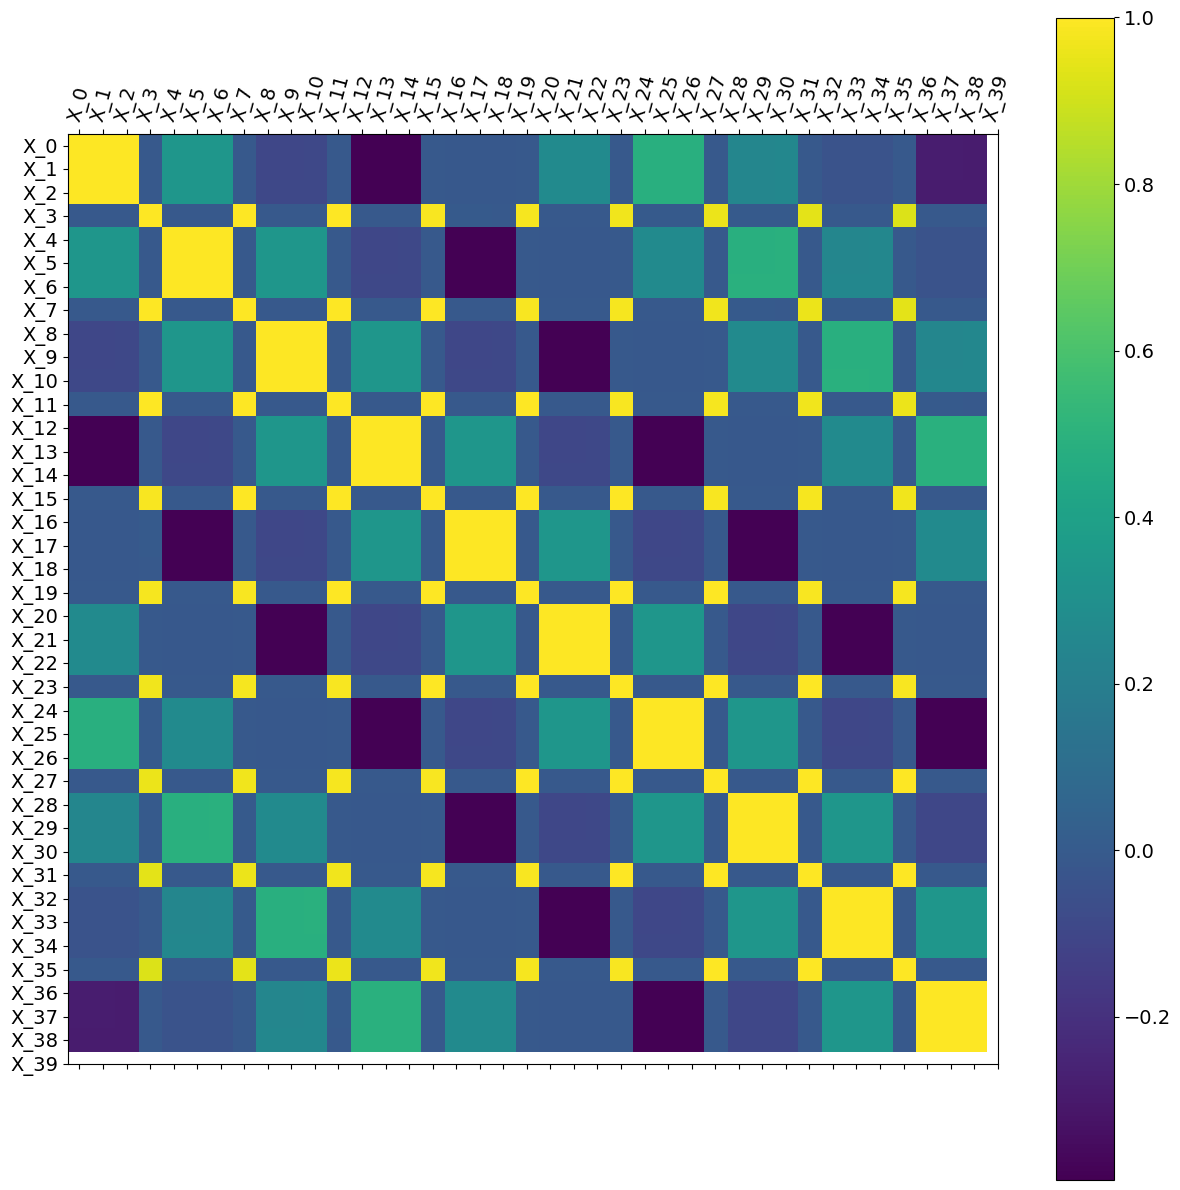

In [30]:
f = plt.figure(figsize=(15, 15))
plt.matshow(spearman_corr, fignum=f.number)
plt.xticks(range(X.shape[1]), X.columns, fontsize=14, rotation=75)
plt.yticks(range(X.shape[1]), X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

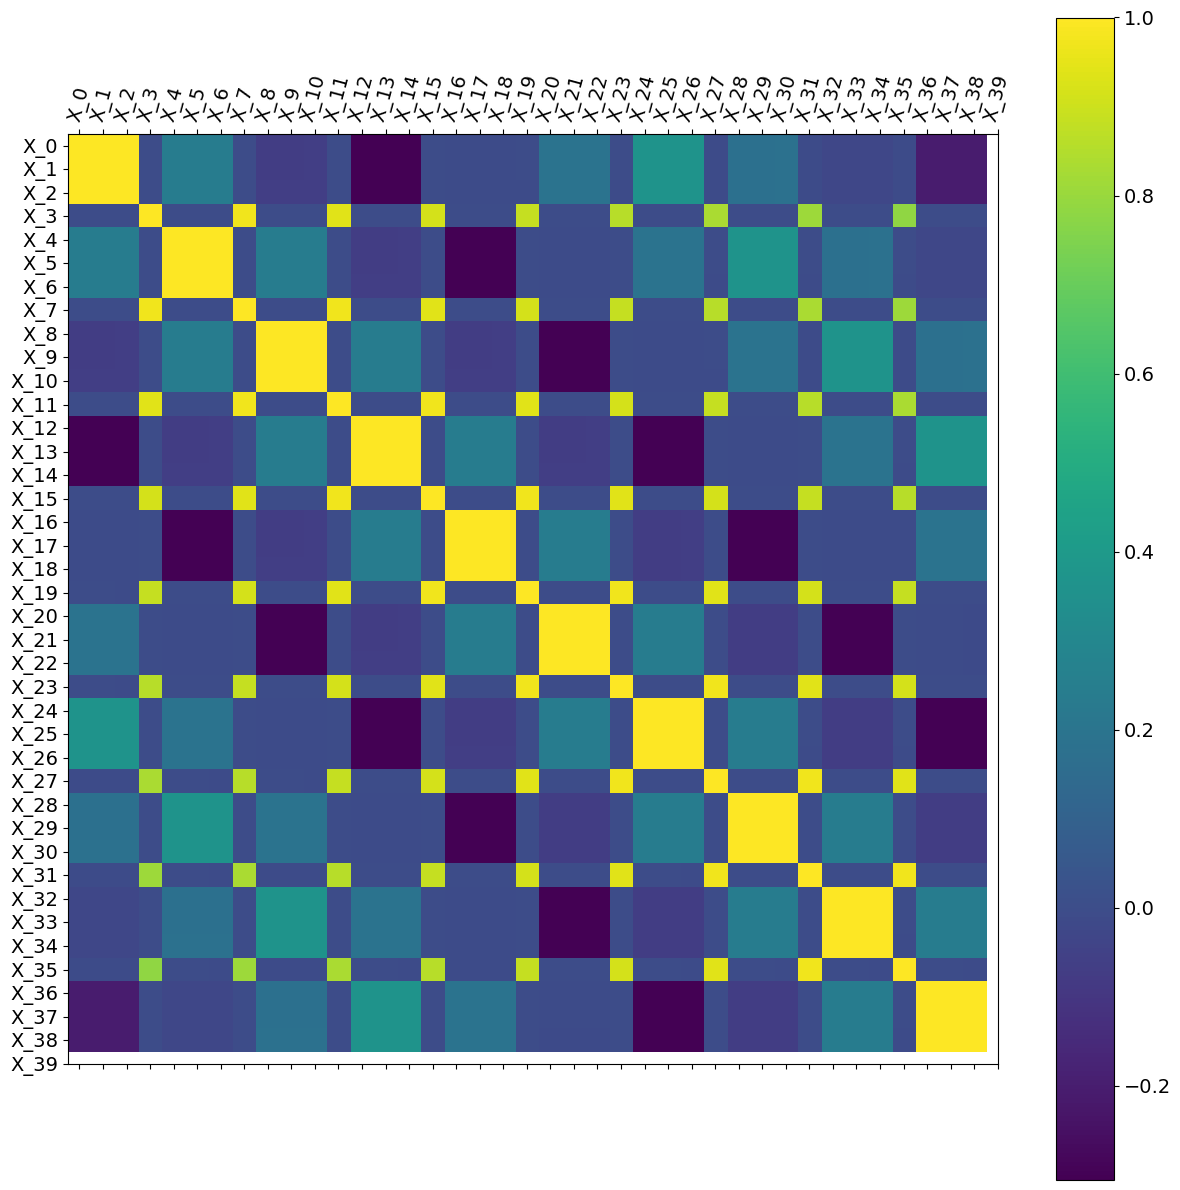

In [31]:
f = plt.figure(figsize=(15, 15))
plt.matshow(kendall_corr, fignum=f.number)
plt.xticks(range(X.shape[1]), X.columns, fontsize=14, rotation=75)
plt.yticks(range(X.shape[1]), X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

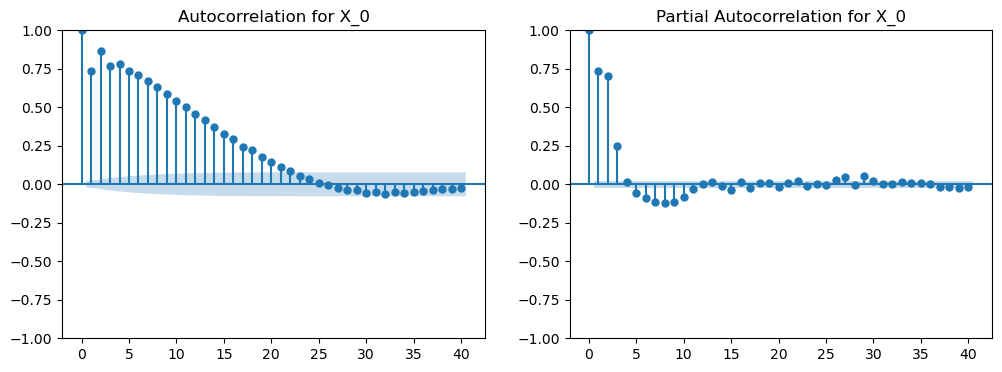

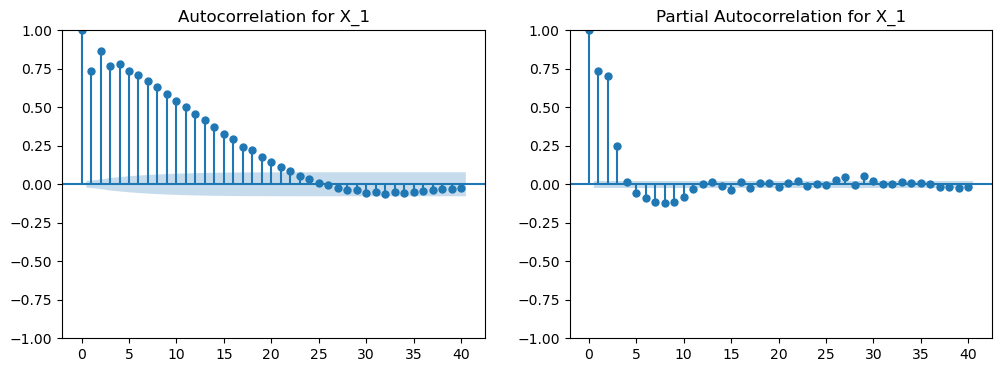

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


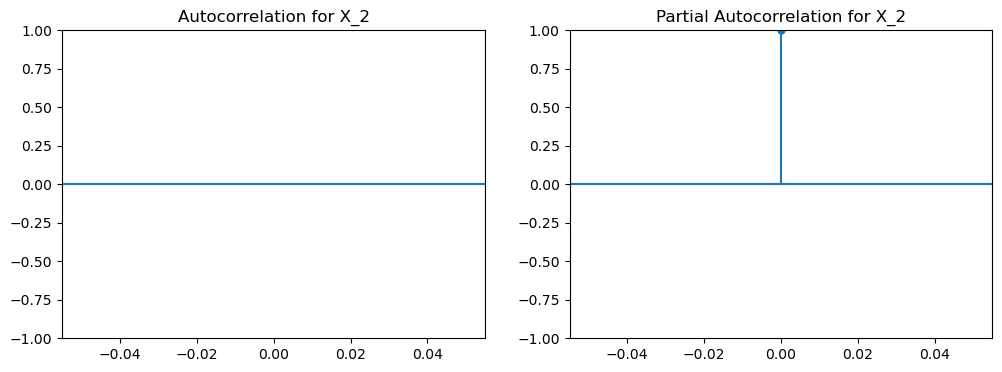

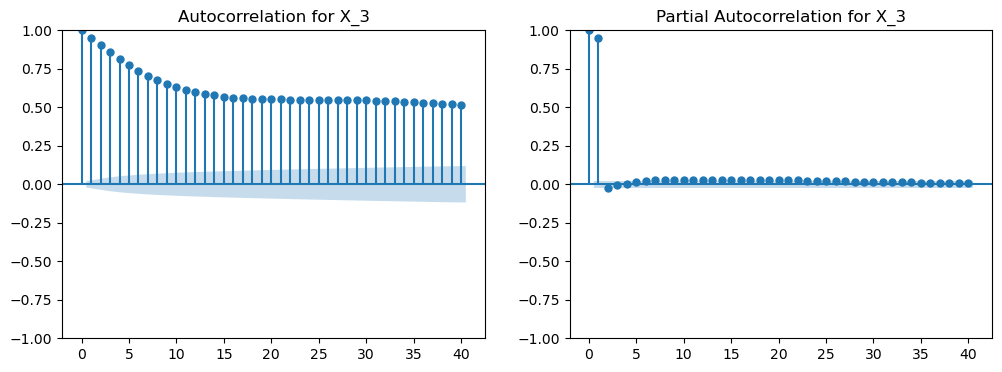

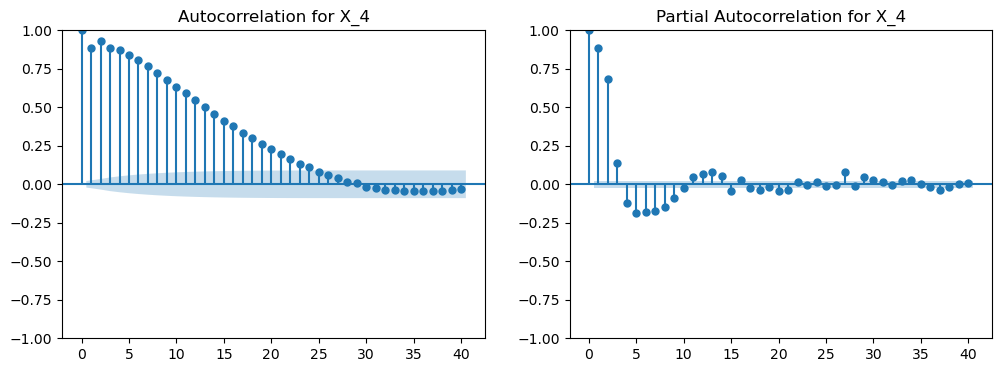

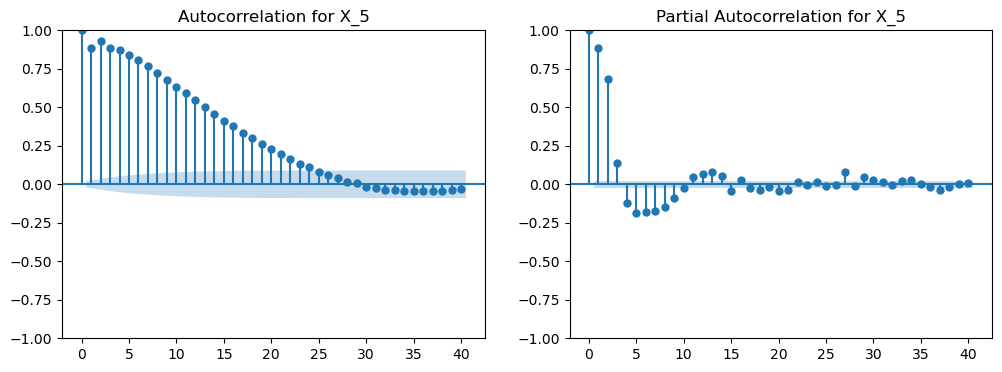

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


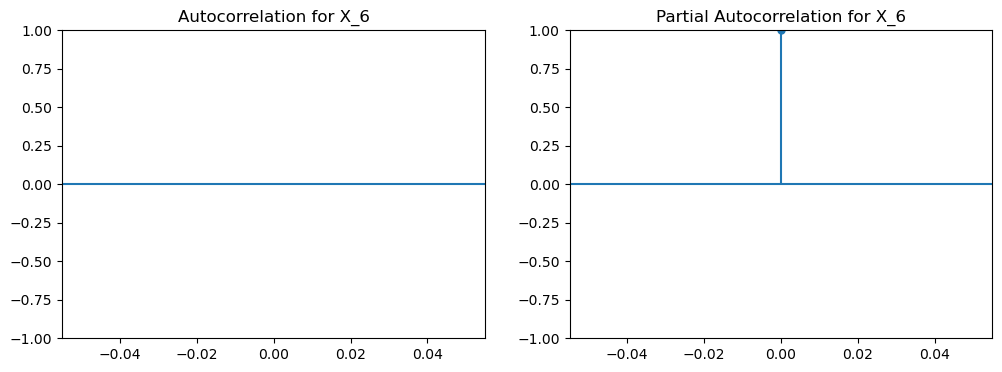

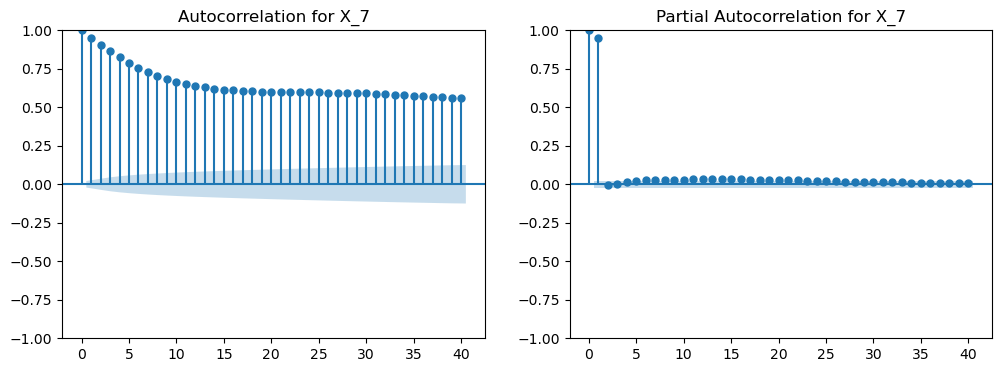

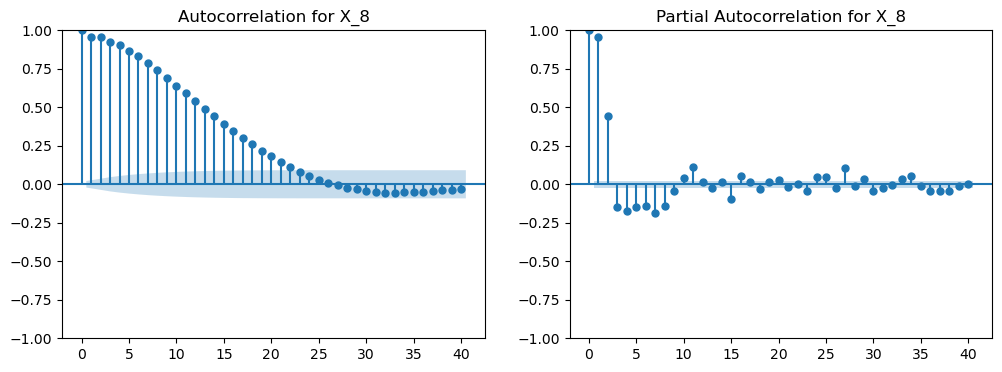

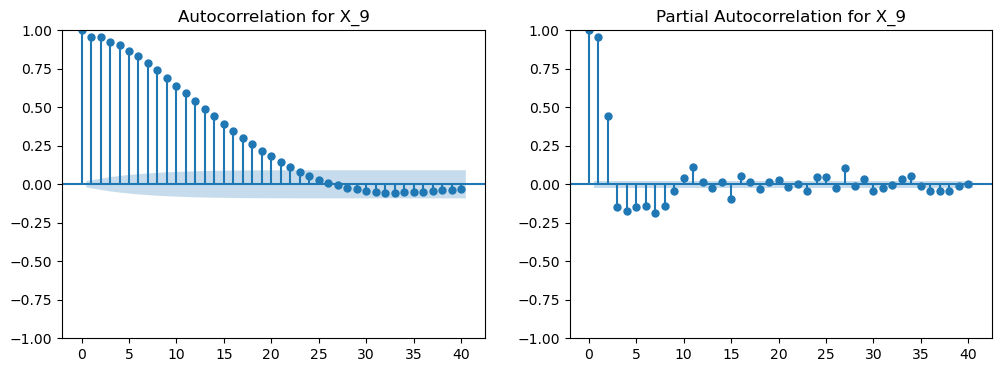

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


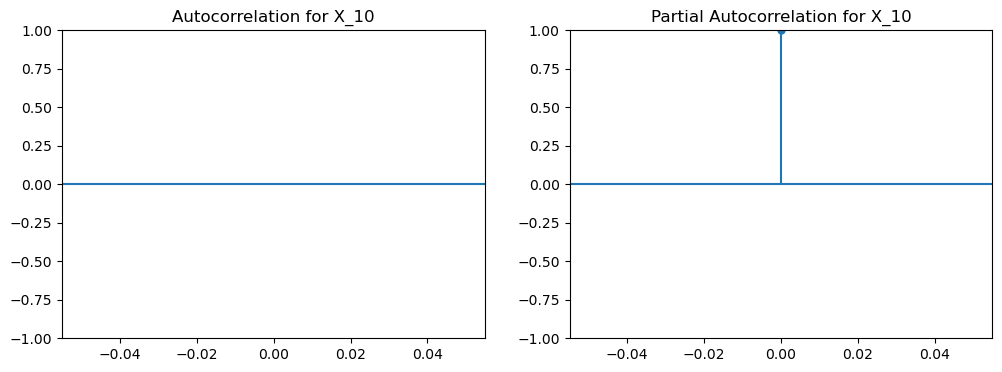

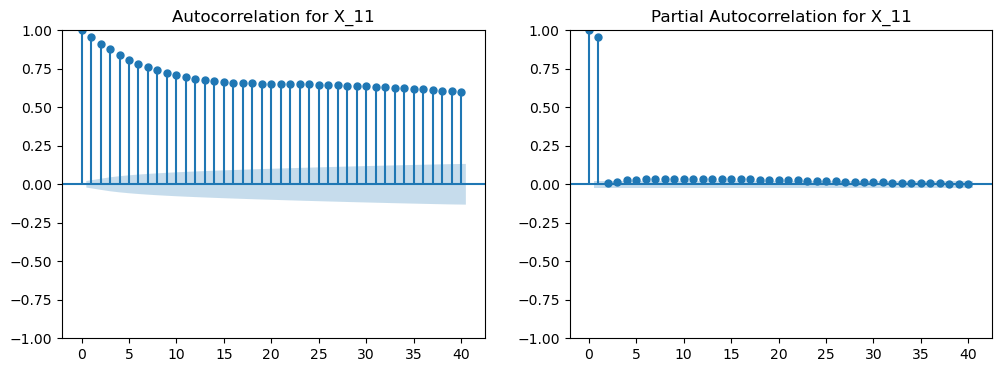

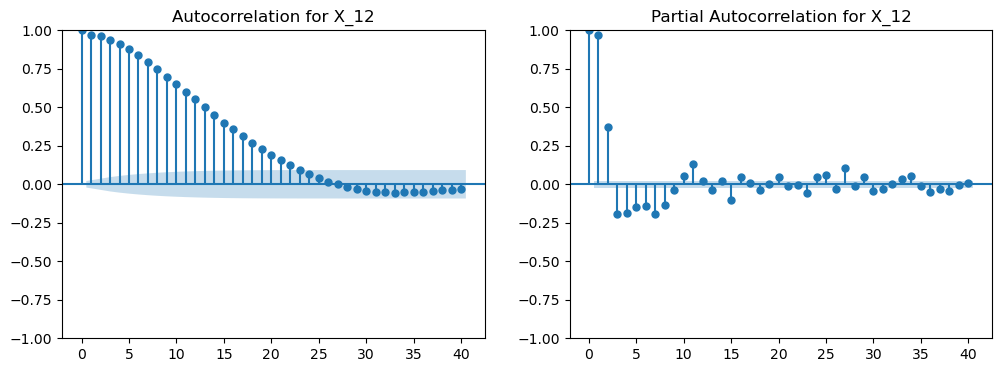

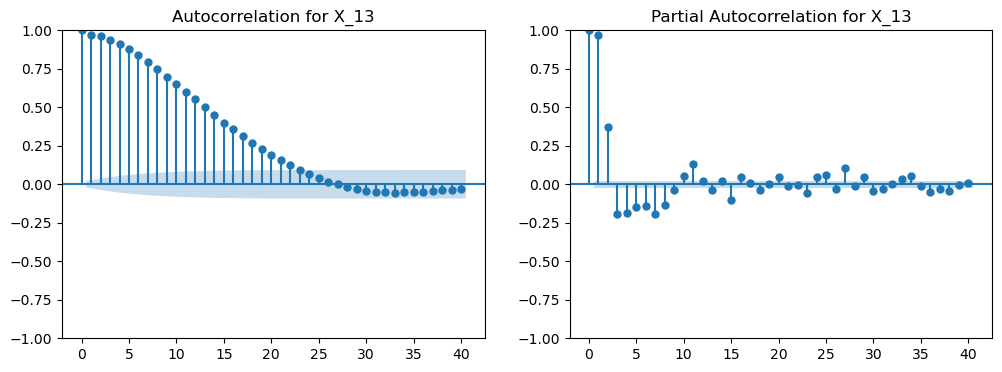

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


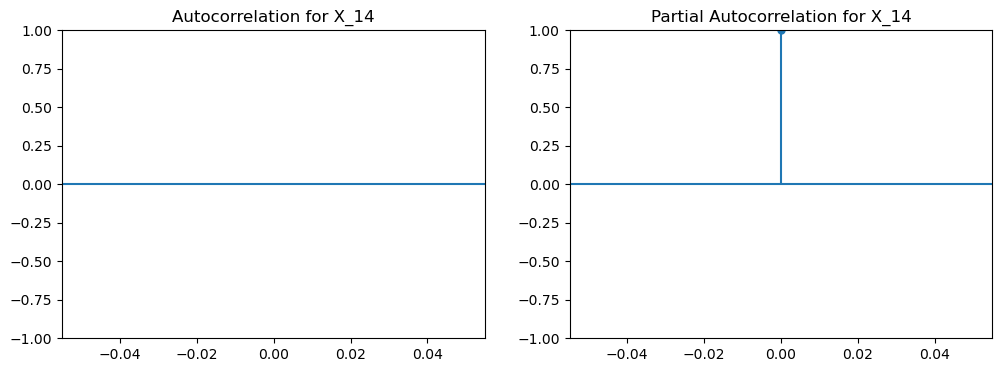

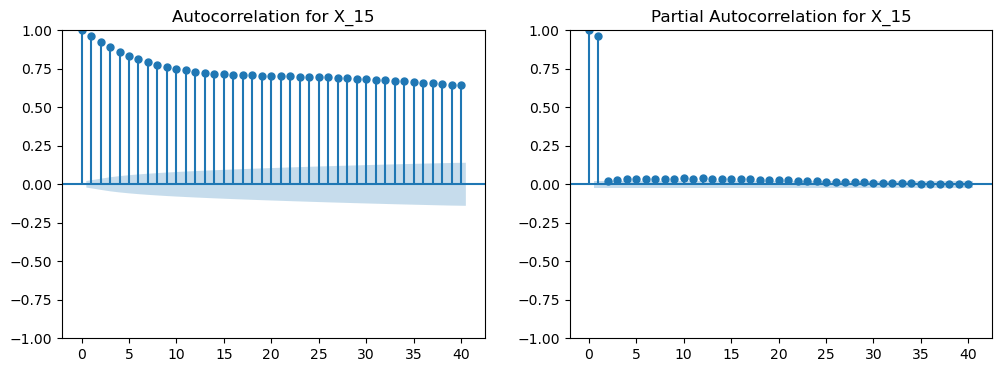

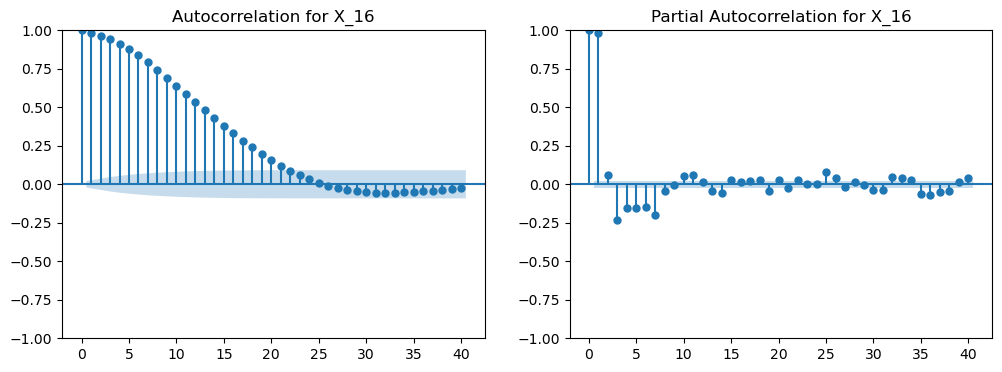

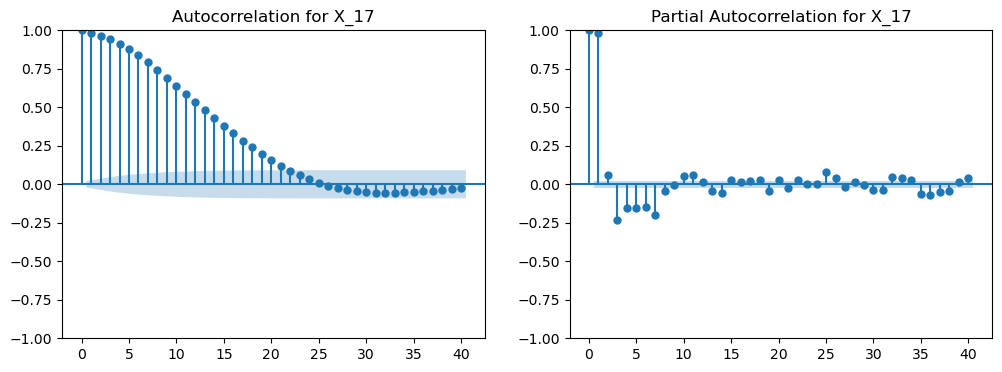

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


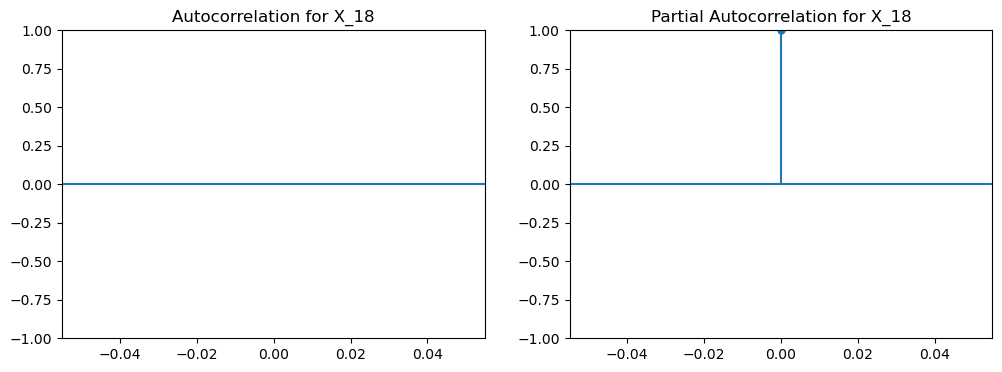

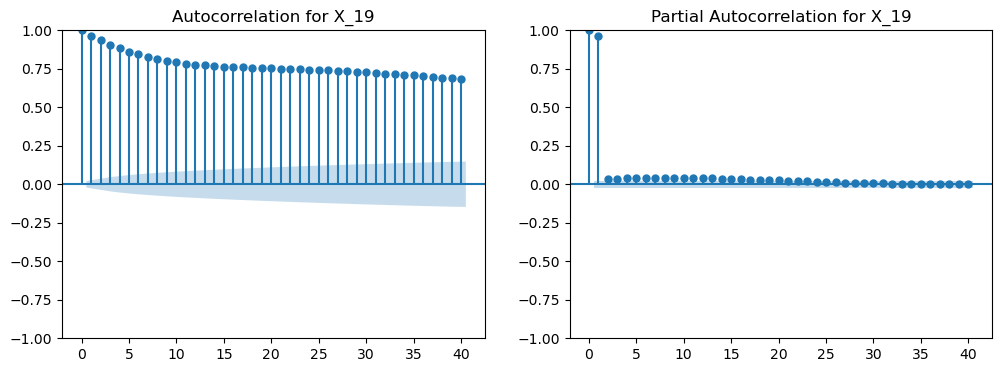

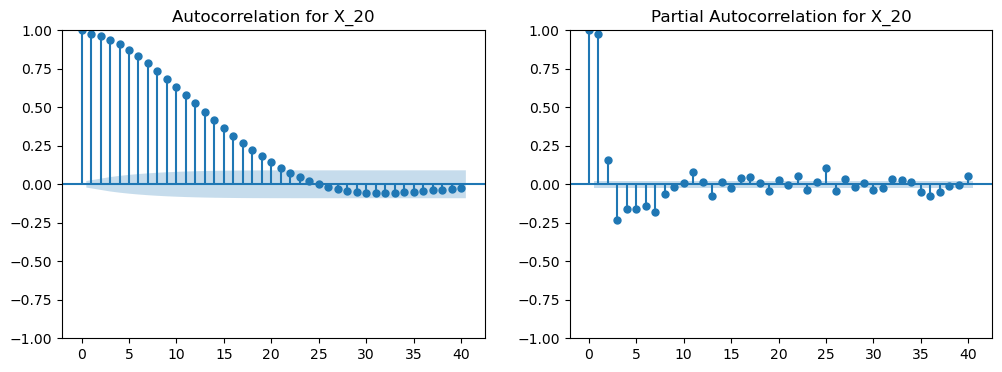

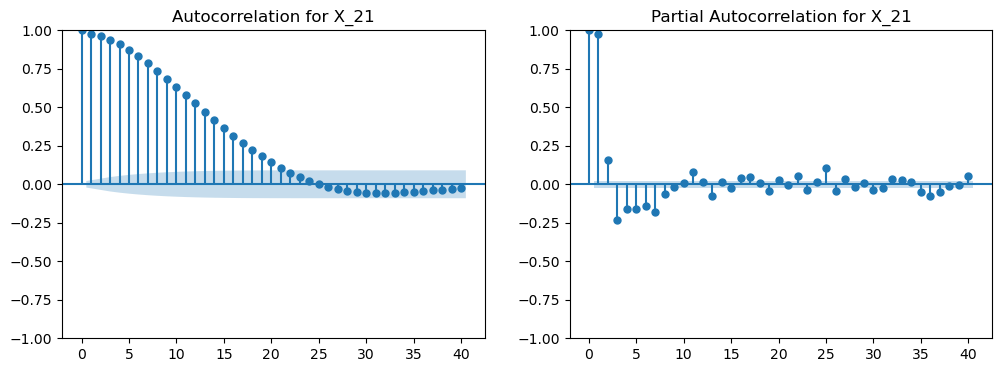

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


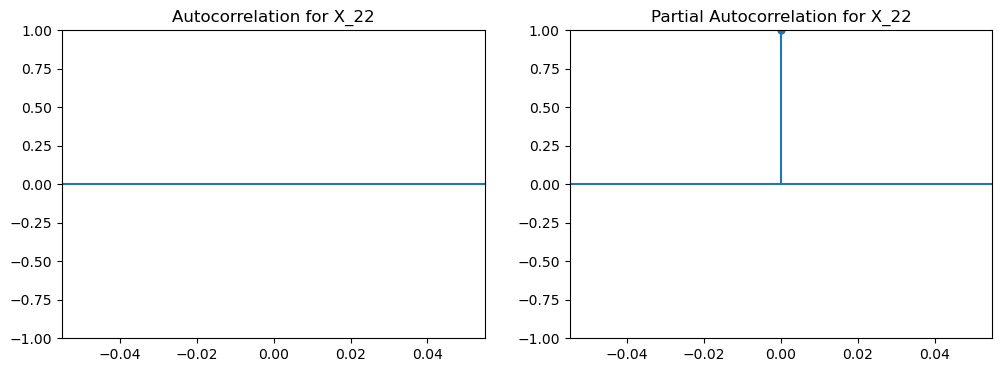

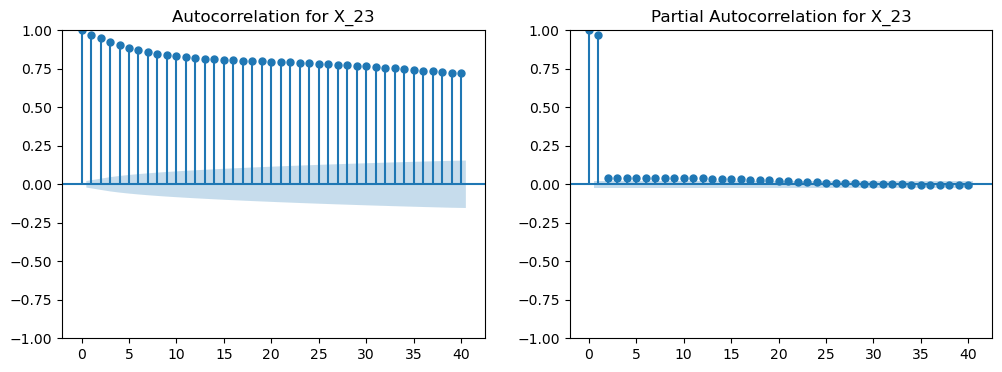

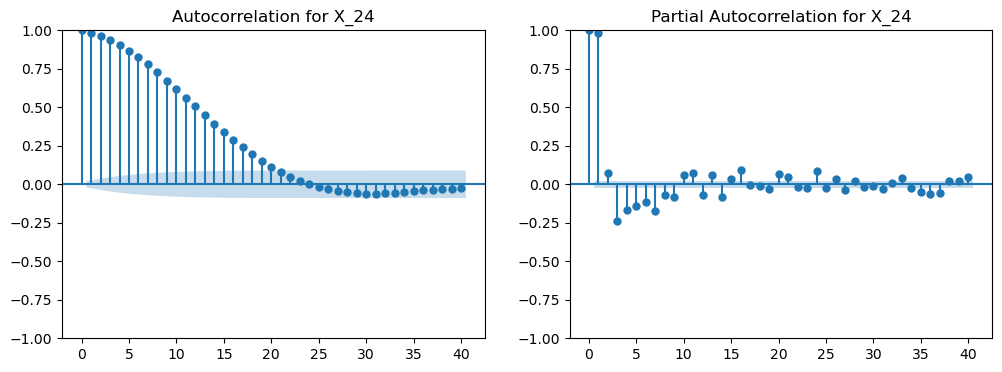

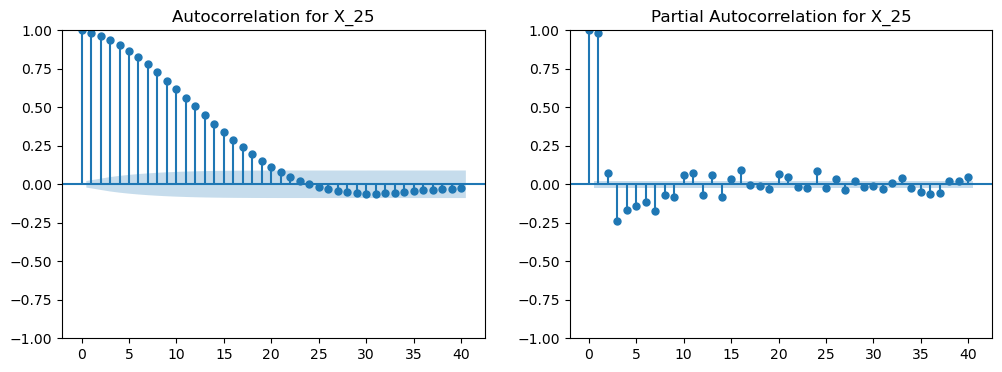

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


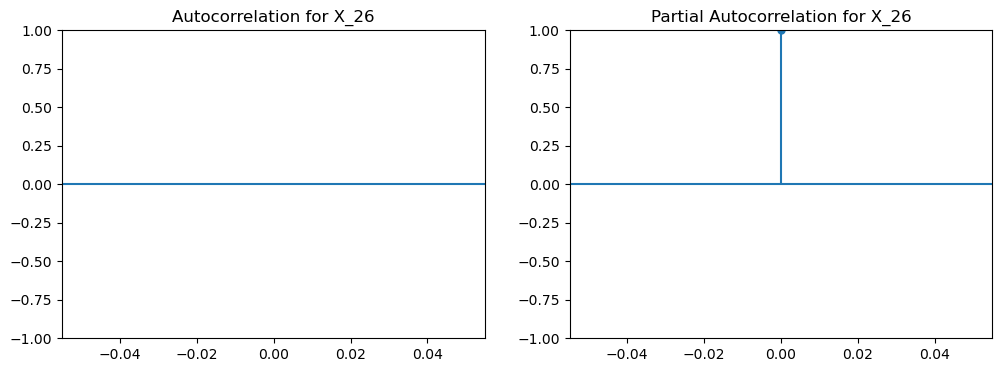

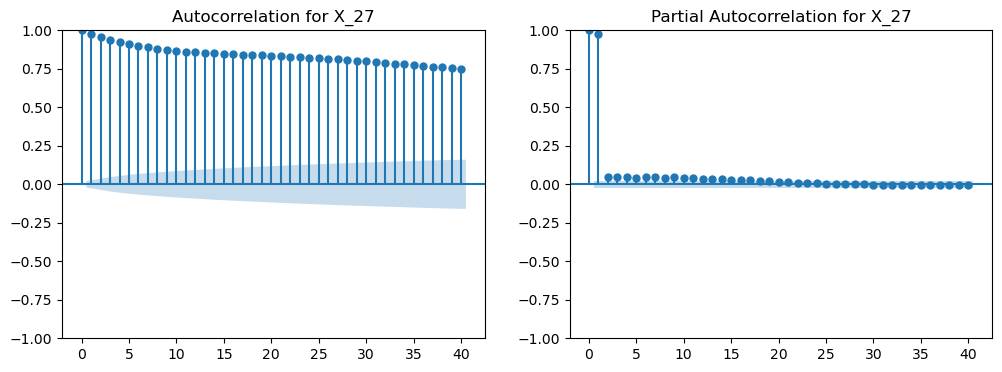

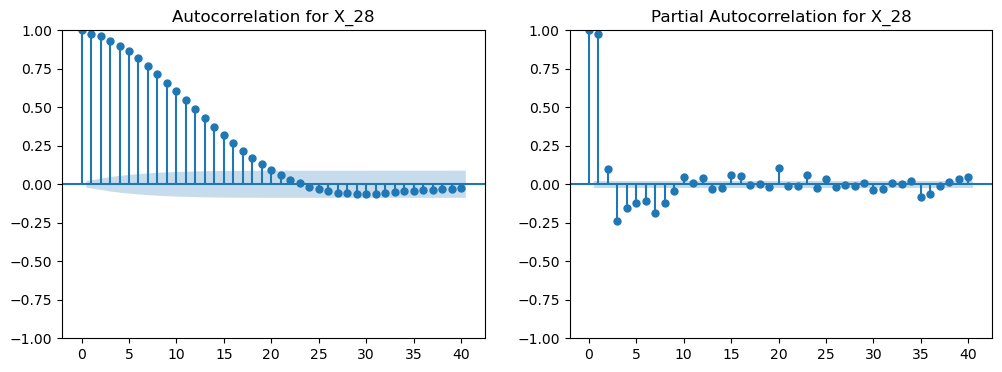

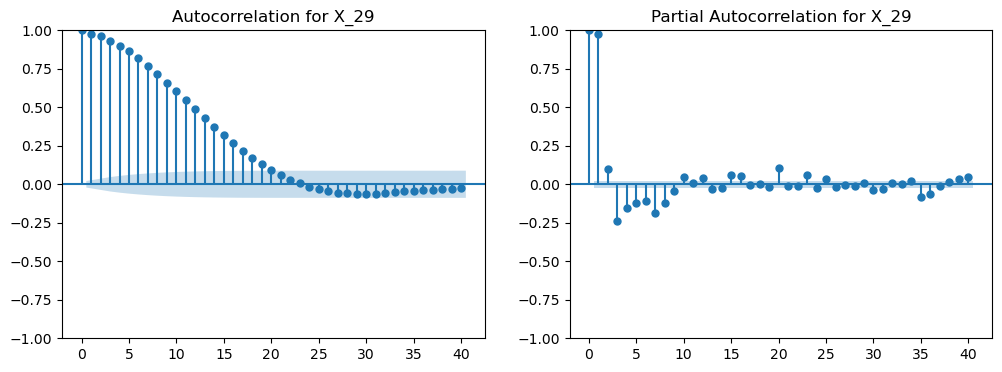

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


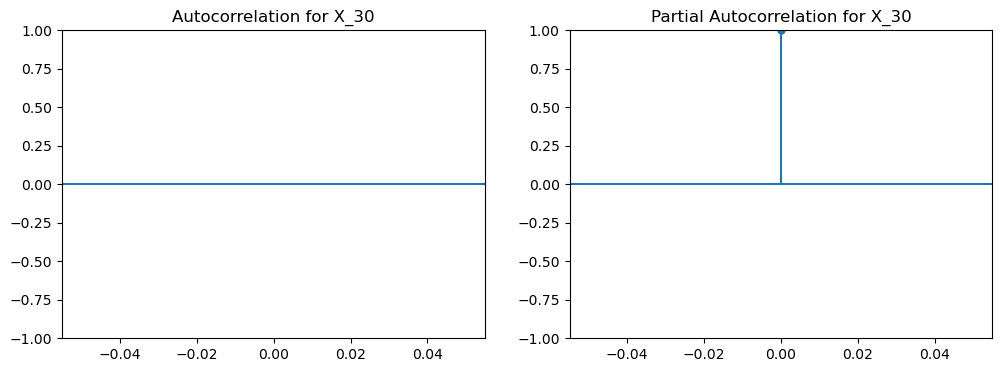

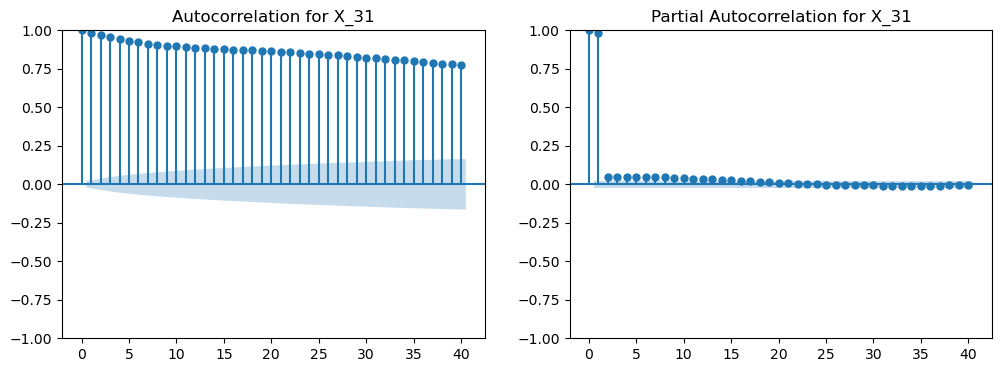

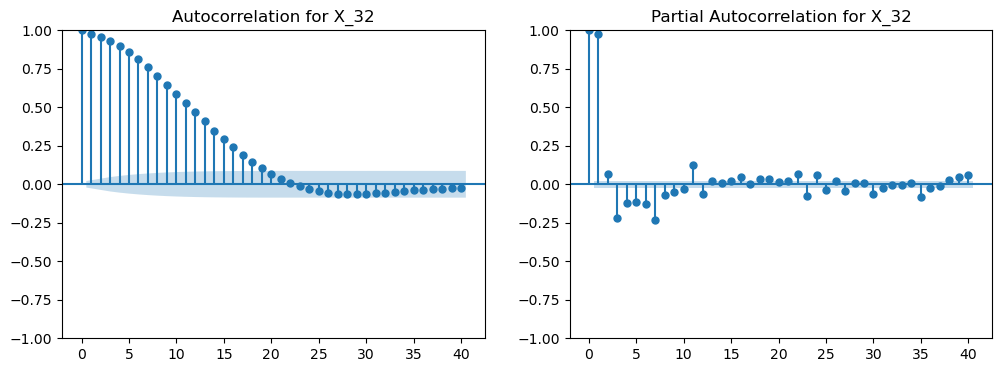

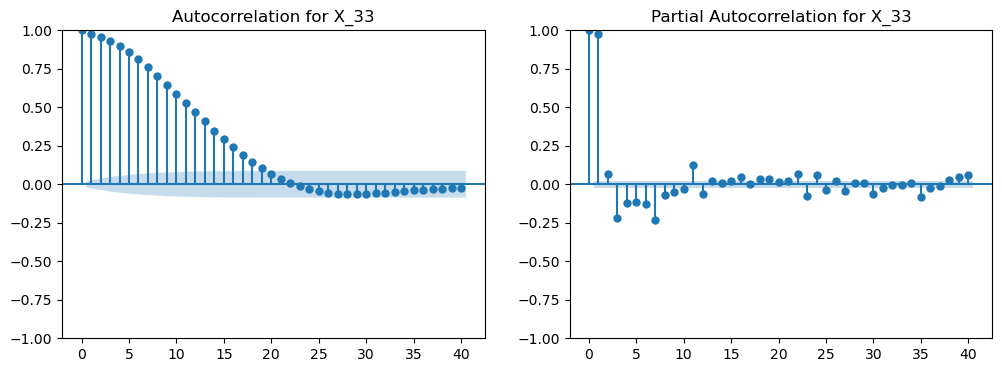

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


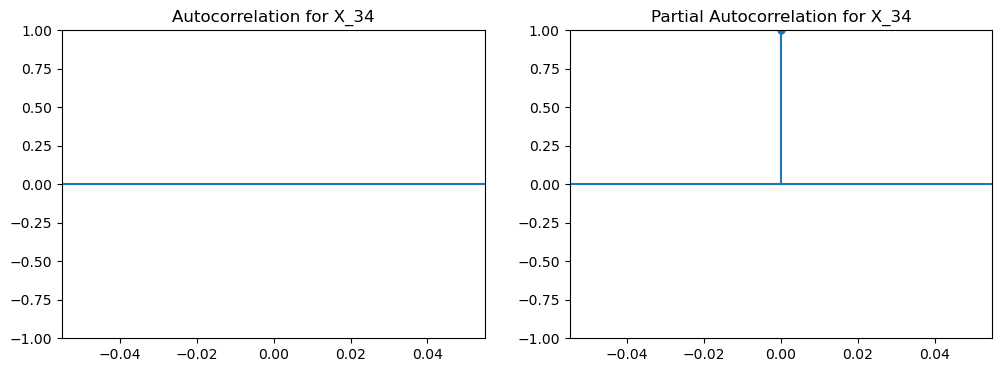

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


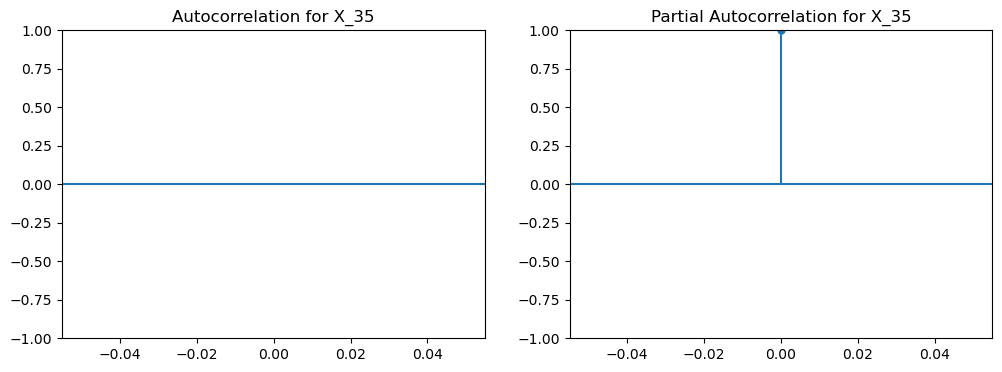

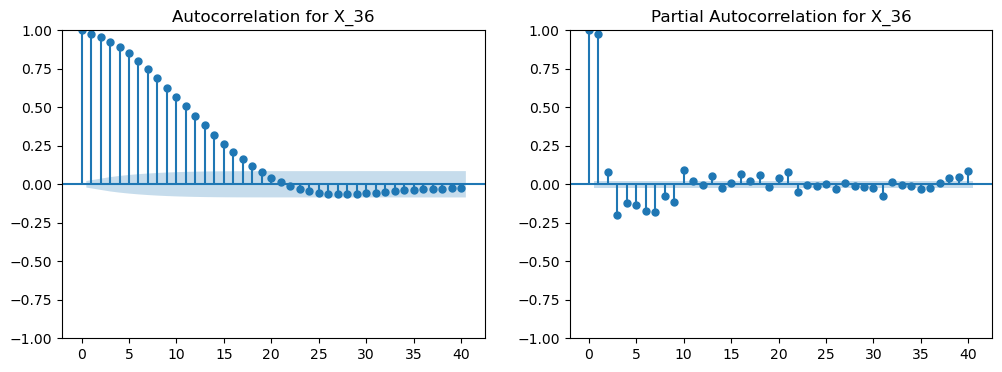

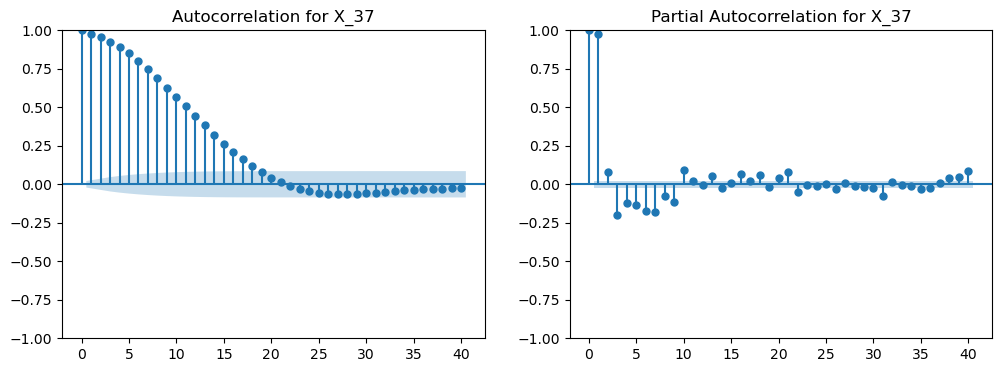

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


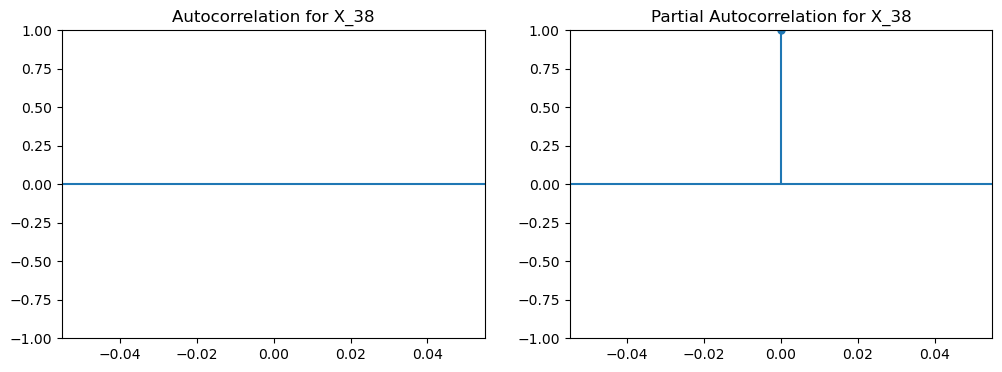

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


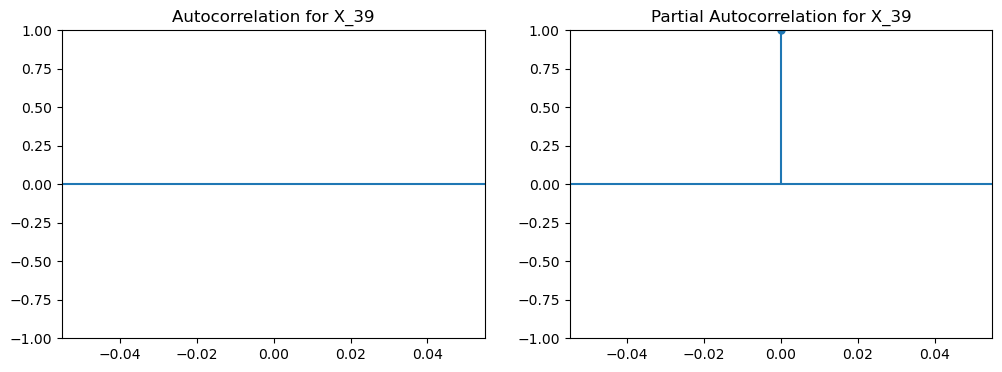

In [32]:
# Compute correlation matrix for all columns
corr_matrix = np.zeros((len(X.columns), len(X.columns)))

for i, col in enumerate(X.columns):
    # Compute ACF and PACF
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    acf = plot_acf(X[col], ax=ax1)
    pacf = plot_pacf(X[col], ax=ax2)
    ax1.set_title('Autocorrelation for {}'.format(col))
    ax2.set_title('Partial Autocorrelation for {}'.format(col))
    plt.show()
    
    # Check if there is at least one line returned by plot_acf
    if acf.lines:
        corr_matrix[i, :] = acf.lines[0].get_ydata()

C:\Users\abood\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


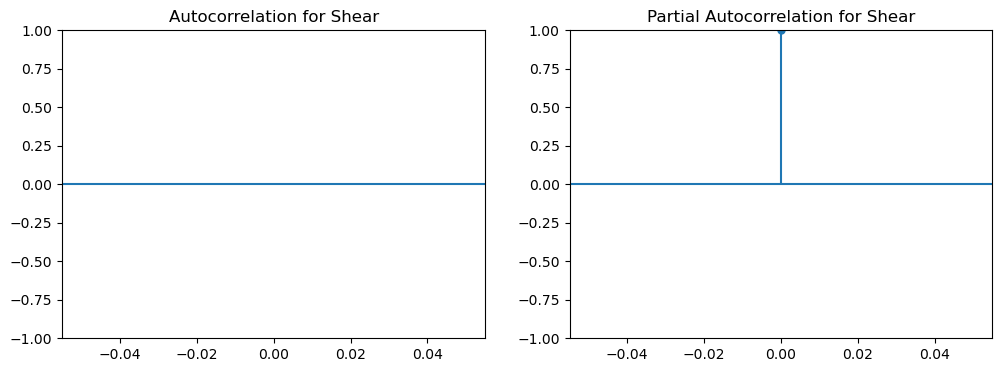

In [33]:
# Compute correlation matrix for all columns
corr_matrix = np.zeros((len(y.columns), len(y.columns)))

for i, col in enumerate(y.columns):
    # Compute ACF and PACF
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    acf = plot_acf(y[col], ax=ax1)
    pacf = plot_pacf(y[col], ax=ax2)
    ax1.set_title('Autocorrelation for {}'.format(col))
    ax2.set_title('Partial Autocorrelation for {}'.format(col))
    plt.show()
    
    # Check if there is at least one line returned by plot_acf
    if acf.lines:
        corr_matrix[i, :] = acf.lines[0].get_ydata()

In [34]:
df = df.dropna()
X = X.dropna()
y = y.dropna()

# Machine Learning Models

In [35]:
X = df.drop(columns = ['Shear'])
y = df[['Shear']]

In [36]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.svm import SVR

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
k_fold = KFold(n_splits=5, shuffle=True, random_state = 2020)

## Lasso

In [45]:
# We are using arbitrary values for the parameters and we will optimize them later. Hyperparameters, Lasso Approach:
alpha = 1.0 #alpha = 0 is equivalent to an ordinary least square but it is not recommended to put zero here!
normalize = False
max_iter = 2000
tol = 0.00001
random_state = None
selection = 'cyclic' # (setting to ‘random’) often leads to significantly faster convergence especially when tol is higher than 1e-4.

lasso = Lasso(alpha=alpha, max_iter = max_iter, tol = tol, random_state = random_state, selection = selection)

In [46]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])
model = lasso

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.values.ravel()):

    #'iloc' can be used when the user doesn’t know the index label:
    #Here we are filtering the data based on indices. Data is divided as 902/225.
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

    #Fitting the model according to given data:
    #Note that model refers to Lasso.
    model.fit(X_train_fold, y_train_fold)

    #Lets check how good is the fitting.
    #'score' returns the coefficient of determination R^2 of the prediction. It is defined as (1 - u/v), 
    # where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
    #The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
  
    # We will first look in the training dataset:
    scoreTraining = model.score(X_train_fold, y_train_fold)
    #Saving our analysis on the list:
    trainingScores.append(scoreTraining)

    #Lets see how good it is on CV dataset:
    scoreCV = model.score(X_cv_fold, y_cv_fold)
    #Saving our analysis on the list:
    cvScores.append(scoreCV)

    #printing the results:
    print('Training Score: ', scoreTraining)
    print('CV Score: ', scoreCV)

#Lets see the overall score for the entire training set (1127)
scoreLasso = model.score(X_train,y_train)
print('-----------------------------------')
print('Lasso Score: ', scoreLasso)
print('-----------------------------------')

Training Score:  0.023936834145651176
CV Score:  0.0030547546917157886
Training Score:  0.029001918123725656
CV Score:  0.011858048409343902
Training Score:  0.018855639080226694
CV Score:  0.020073988074544857
Training Score:  0.027061953841230002
CV Score:  0.016590487302286183
Training Score:  0.012454699474938935
CV Score:  0.01564181982056978
-----------------------------------
Lasso Score:  0.013463954351655705
-----------------------------------


In [47]:
# parameter vector (w in the cost function formula):
print(model.coef_)

[0.00021033 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [49]:
# Looking for the best alpha value:
alphas = np.logspace(-5, 1, 10)
grid = [{'alpha': alphas}]
#Setting the search:
# For scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
gridSearch = GridSearchCV(lasso, grid, scoring='r2', cv=k_fold, refit=True)
gridSearch.fit(X_train, y_train)
results = gridSearch.cv_results_
print('Best R^2 obtained:', gridSearch.best_score_)
print('alpha value for the best case:', gridSearch.best_estimator_.alpha)

C:\Users\abood\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.061e-02, tolerance: 1.816e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\abood\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.555e-02, tolerance: 1.905e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\abood\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.286e-02, toleranc

Best R^2 obtained: 0.9997359468343598
alpha value for the best case: 1e-05


C:\Users\abood\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e-01, tolerance: 2.247e-03
  model = cd_fast.enet_coordinate_descent(


In [50]:
print('Best R^2 obtained:', gridSearch.best_score_)
print('alpha value for the best case:', gridSearch.best_estimator_.alpha)

Best R^2 obtained: 0.9997359468343598
alpha value for the best case: 1e-05


In [51]:
#Saving the best parameters back to model:
lasso = gridSearch.best_estimator_
#Alpha value of the model:
lasso.alpha

1e-05

In [52]:
#Lets check the keys to plot them:
results.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

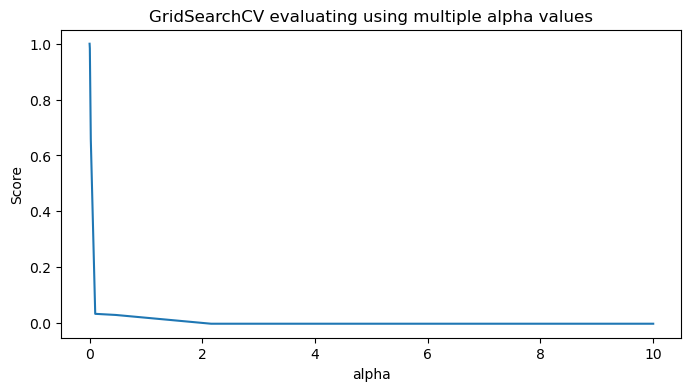

In [53]:
# Plotting the results
plt.figure(figsize=(8, 4))
plt.title("GridSearchCV evaluating using multiple alpha values",
          fontsize=12)
plt.xlabel("alpha")
plt.ylabel("Score")
# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_alpha'].data, dtype=float)
Y_axis = np.array(results['mean_test_score'].data, dtype=float)
plt.plot(X_axis,Y_axis)
plt.show()

[]

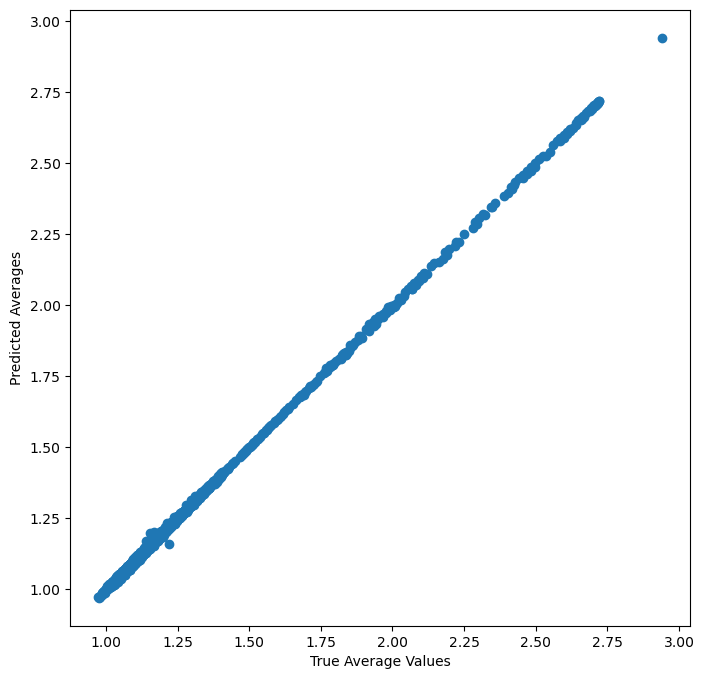

In [54]:
# Calling trained model for predictions:
Y_train_predictions = pd.Series(lasso.predict(X_train).flatten(),index=X_train.index)
#Visualization of the accuracy:
plt.figure(figsize=(8, 8))
#a = plt.axes(aspect='equal')
plt.scatter(y_train, Y_train_predictions)
plt.xlabel('True Average Values')
plt.ylabel('Predicted Averages')
plt.plot()

Text(0, 0.5, 'Count')

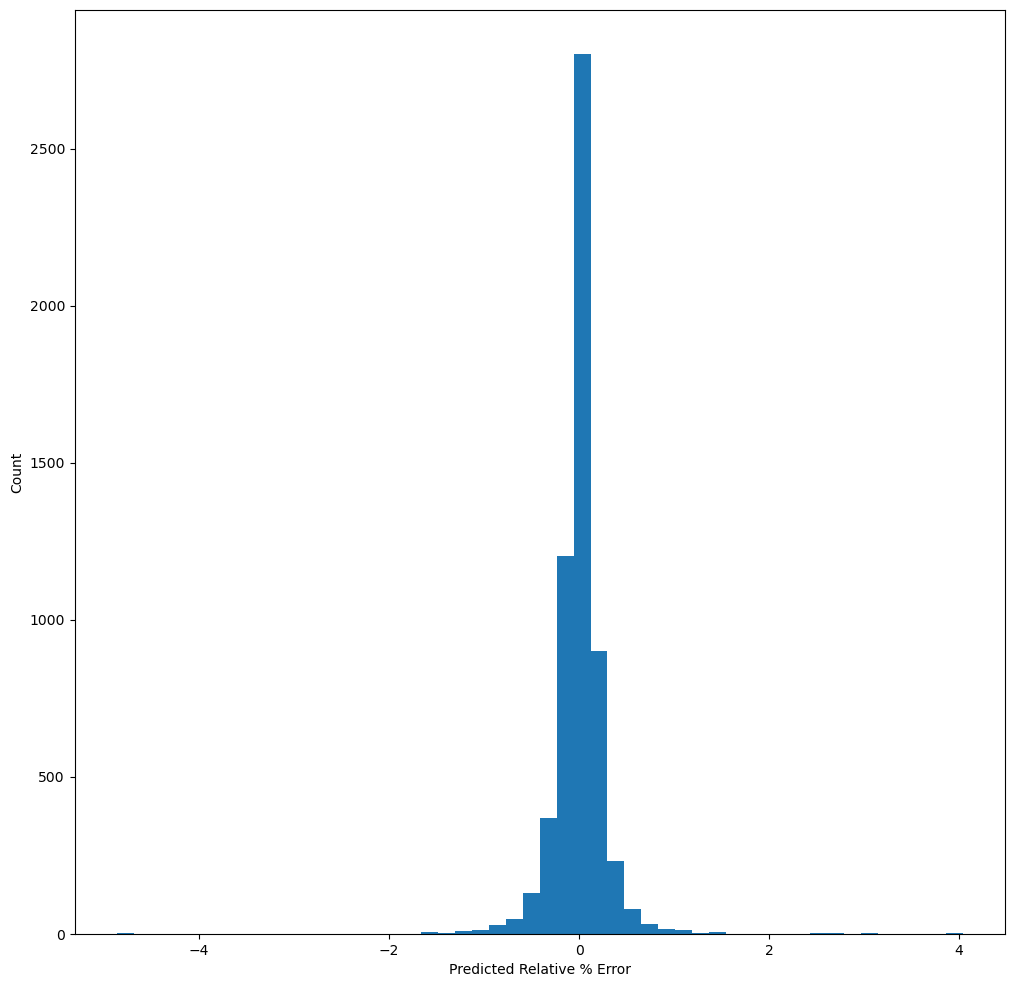

In [55]:
# Calculating the error variations:
error_nn = (Y_train_predictions - y_train['Shear'])/y_train['Shear']*100
plt.figure(figsize=(12, 12))
plt.hist(error_nn, bins=50)
#plt.xlim(-50, 50)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

[]

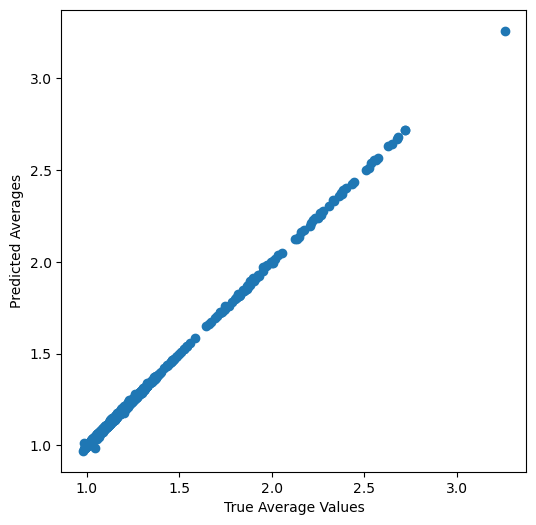

In [56]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(lasso.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
plt.figure(figsize=(6, 6))
#a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Average Values')
plt.ylabel('Predicted Averages')
plt.savefig('lasso.png')
plt.plot()

Text(0, 0.5, 'Count')

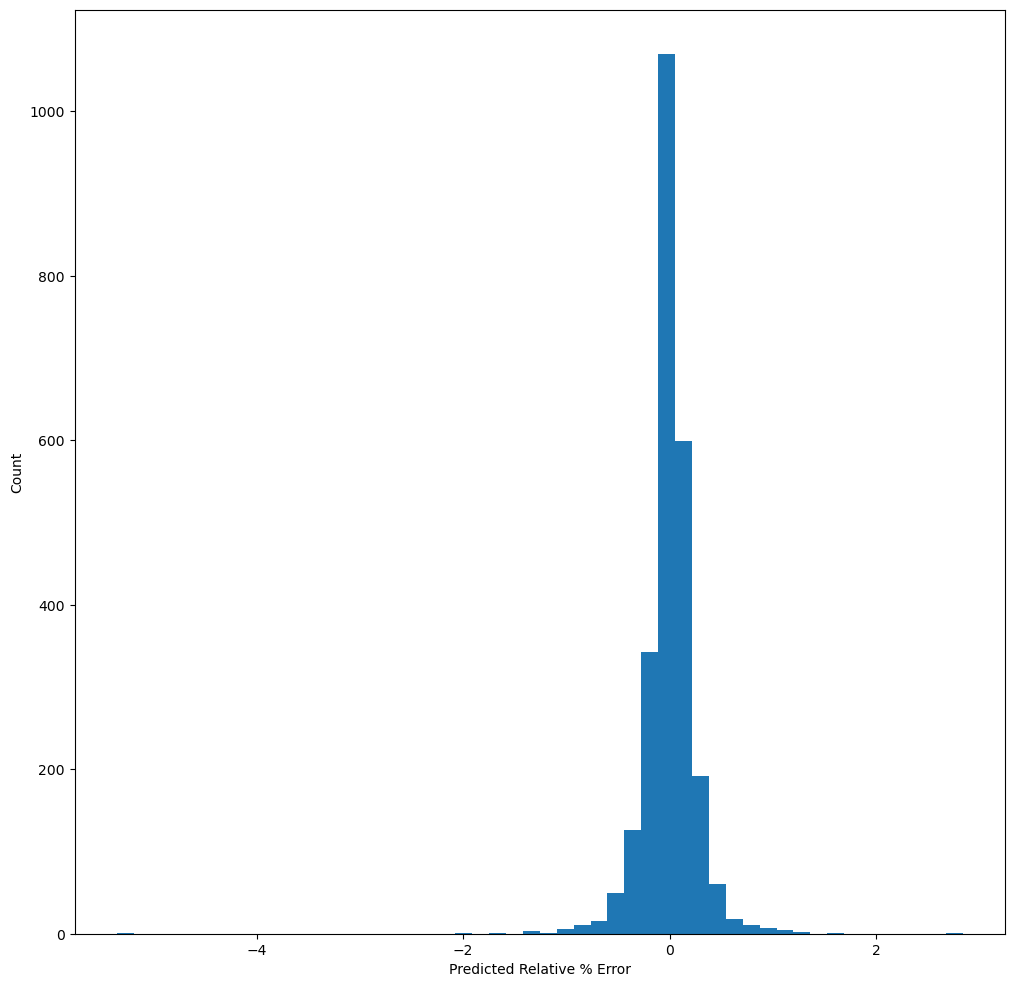

In [57]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test['Shear'])/y_test['Shear']*100
plt.figure(figsize=(12, 12))
plt.hist(error_nn, bins=50)
#plt.xlim(-150, 150)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [58]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test['Shear'])/y_test['Shear']*100
np.average(abs_error_nn)

0.1579265626470184

## SVM

In [59]:
kernel='linear' 
gamma='scale' #Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. When scaled, uses 1 / (n_features * X.var()) as value of gamma.
C=1.0
epsilon=0.1    # Default
shrinking=True # Whether to use the shrinking heuristic. 
tol=0.00001

#Setting the model:
svr = SVR(kernel= kernel, gamma=gamma, tol=tol, C=C, epsilon=epsilon, shrinking=shrinking)

In [98]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

####Modified###
model = svr

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.values.ravel()):

    #'iloc' can be used when the user doesn’t know the index label:
    #Here we are filtering the data based on indices. Data is divided as 902/225.
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

    #Fitting the model according to given data:
    #Note that model refers to Lasso.
    model.fit(X_train_fold, y_train_fold)

    #Lets check how good is the fitting.
    #'score' returns the coefficient of determination R^2 of the prediction. It is defined as (1 - u/v), 
    # where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
    #The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
  
    # We will first look in the training dataset:
    scoreTraining = model.score(X_train_fold, y_train_fold)
    #Saving our analysis on the list:
    trainingScores.append(scoreTraining)

    #Lets see how good it is on CV dataset:
    scoreCV = model.score(X_cv_fold, y_cv_fold)
    #Saving our analysis on the list:
    cvScores.append(scoreCV)

    #printing the results:
    print('Training Score: ', scoreTraining)
    print('CV Score: ', scoreCV)

#Lets see the overall score for the entire training set (1127)

####Modified###
scoreSVM = model.score(X_train,y_train)
print('-----------------------------------')
print('SVM Regression Score: ', scoreSVM)
print('-----------------------------------')

C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Score:  0.8974552318350504
CV Score:  0.89151491002914


C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Score:  0.9072033325999818
CV Score:  0.8661809954293294


C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Score:  0.9081546608724576
CV Score:  0.9154077622420955


C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Score:  0.8916726755006736
CV Score:  0.8991008146831017


C:\Users\abood\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Score:  0.9188715665402184
CV Score:  0.9326554015618301
-----------------------------------
SVM Regression Score:  0.9220286848892669
-----------------------------------


[]

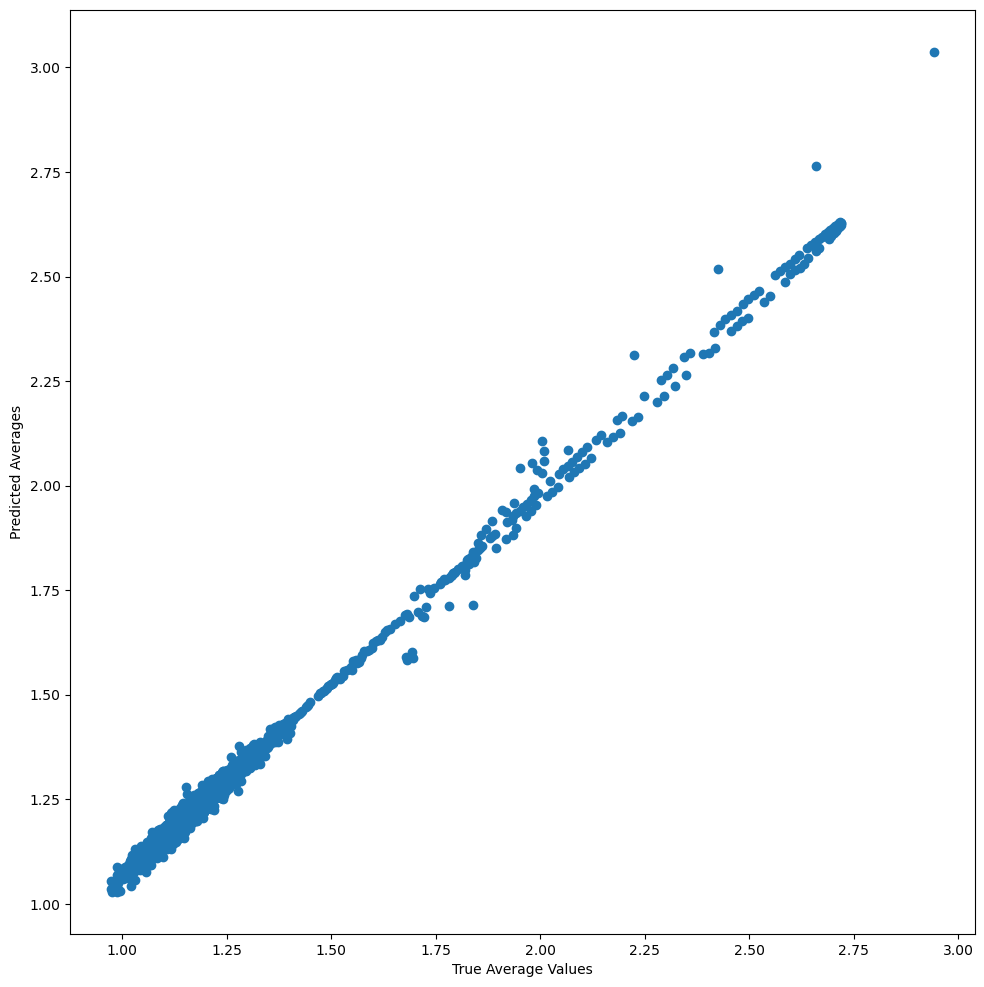

In [99]:
# Calling trained model for predictions:
Y_train_predictions = pd.Series(model.predict(X_train).flatten(),index=X_train.index)
#Visualization of the accuracy:
plt.figure(figsize=(12, 12))
a = plt.axes(aspect='equal')
plt.scatter(y_train, Y_train_predictions)
plt.xlabel('True Average Values')
plt.ylabel('Predicted Averages')
plt.savefig('svm.png')
plt.plot()

Text(0, 0.5, 'Count')

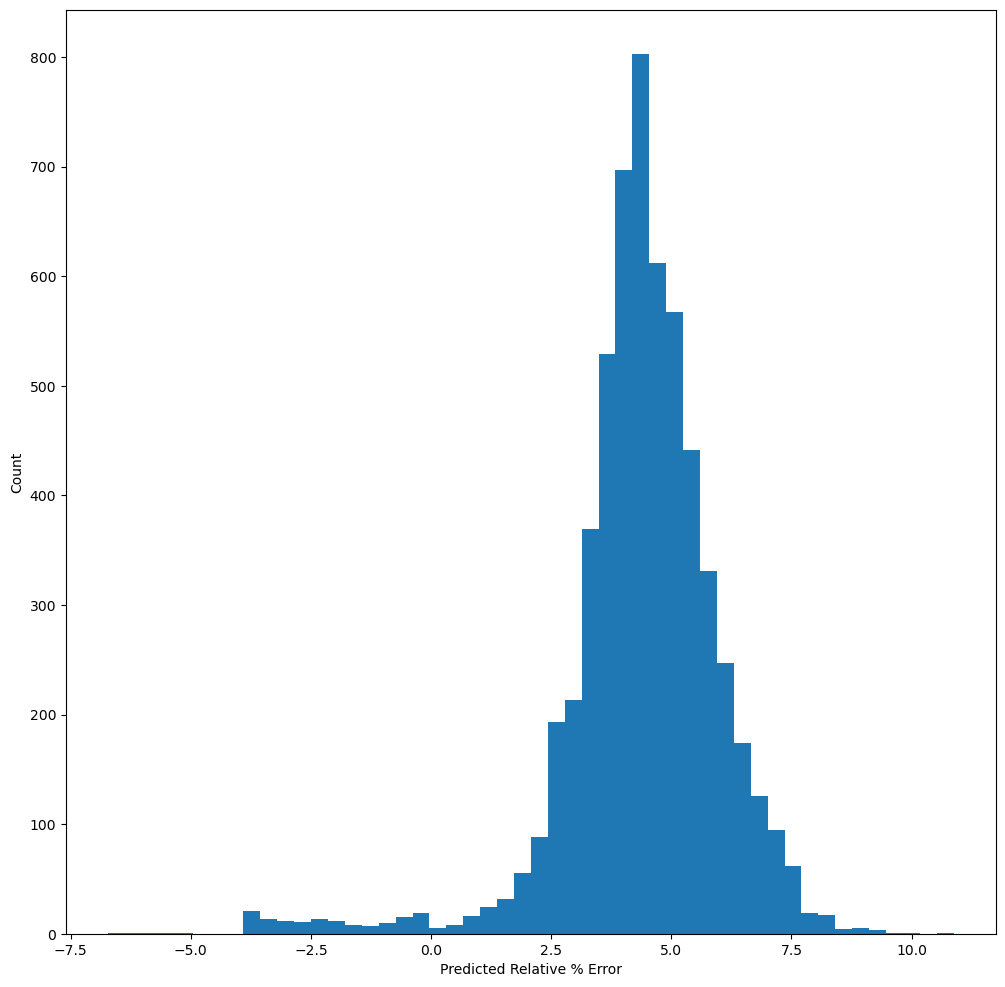

In [100]:
# Calculating the error variations:
error_nn = (Y_train_predictions - y_train['Shear'])/y_train['Shear']*100
plt.figure(figsize=(12, 12))
plt.hist(error_nn, bins=50)
#plt.xlim(-150, 150)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

[]

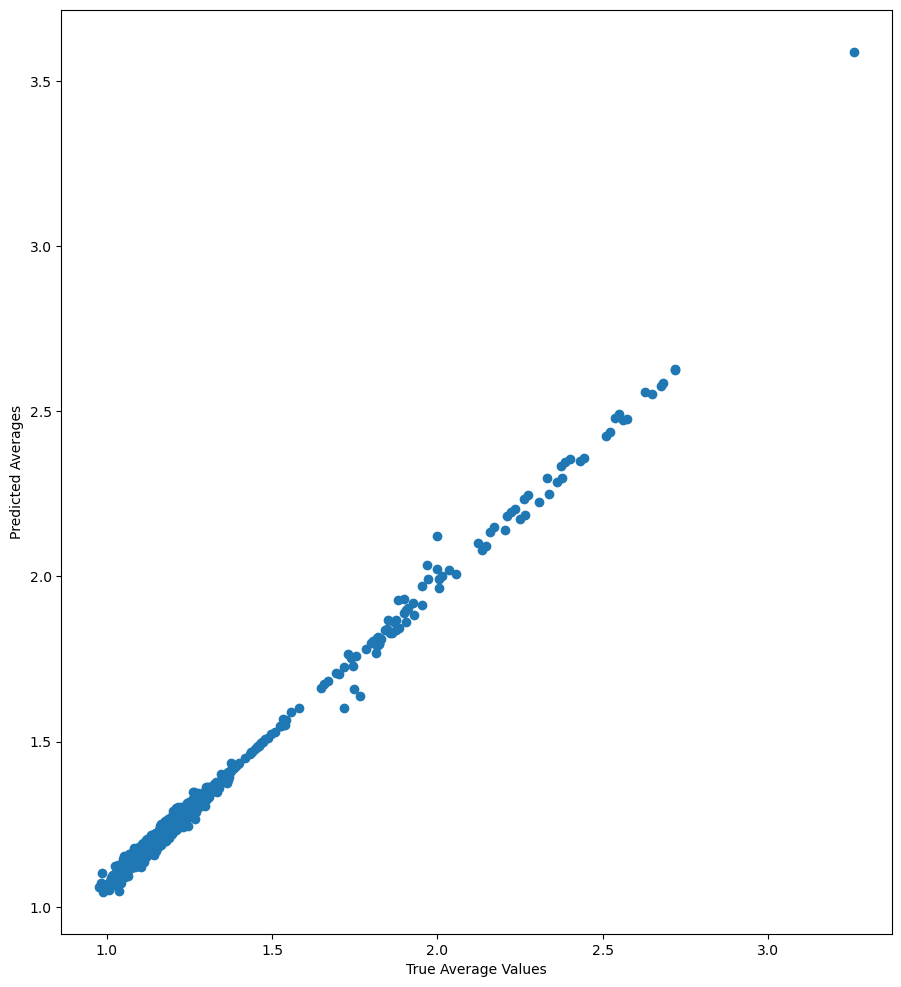

In [101]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
plt.figure(figsize=(12, 12))
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Average Values')
plt.ylabel('Predicted Averages')
plt.savefig('svm.png')
plt.plot()

Text(0, 0.5, 'Count')

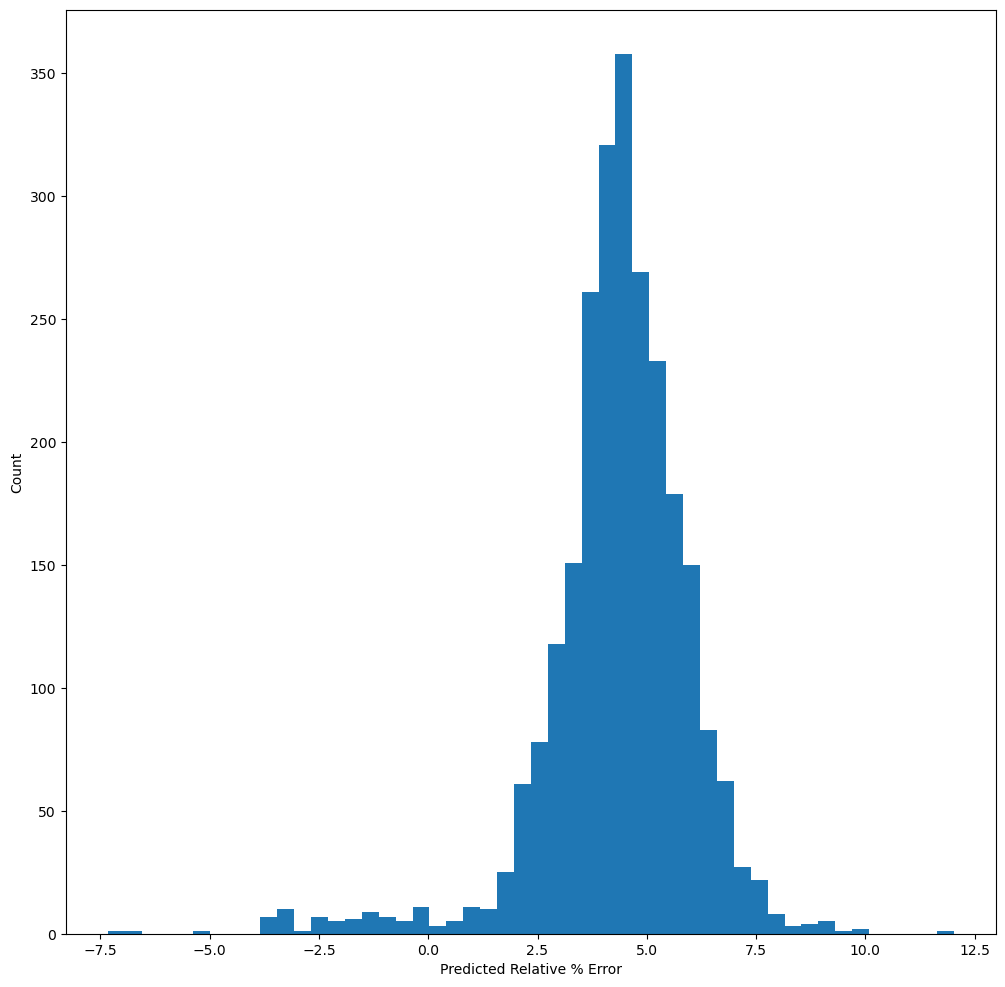

In [102]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test['Shear'])/y_test['Shear']*100
plt.figure(figsize=(12, 12))
plt.hist(error_nn, bins=50)
#plt.xlim(-150, 150)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [103]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test['Shear'])/y_test['Shear']*100
np.average(abs_error_nn)

4.454930690869899

## XGBoost

In [70]:
!pip install xgboost --user

     ---------------------------------------- 99.7/99.7 MB 3.5 MB/s eta 0:00:00


In [71]:
import xgboost as xgb

In [72]:
#Setting the model:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # specify the loss function
    n_estimators=100, # specify the number of trees
    learning_rate=0.1, # specify the learning rate
    max_depth=5, # specify the maximum depth of each tree
    subsample=0.8, # specify the fraction of samples to use for each tree
    colsample_bytree=0.8, # specify the fraction of features to use for each tree
    random_state=42 # specify a random seed for reproducibility
)

In [92]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

####Modified###
model = xgb_model

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.values.ravel()):

    #'iloc' can be used when the user doesn’t know the index label:
    #Here we are filtering the data based on indices. Data is divided as 902/225.
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

    #Fitting the model according to given data:
    #Note that model refers to Lasso.
    model.fit(X_train_fold, y_train_fold)

    #Lets check how good is the fitting.
    #'score' returns the coefficient of determination R^2 of the prediction. It is defined as (1 - u/v), 
    # where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
    #The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
  
    # We will first look in the training dataset:
    scoreTraining = model.score(X_train_fold, y_train_fold)
    #Saving our analysis on the list:
    trainingScores.append(scoreTraining)

    #Lets see how good it is on CV dataset:
    scoreCV = model.score(X_cv_fold, y_cv_fold)
    #Saving our analysis on the list:
    cvScores.append(scoreCV)

    #printing the results:
    print('Training Score: ', scoreTraining)
    print('CV Score: ', scoreCV)

#Lets see the overall score for the entire training set (1127)

####Modified###
scoreXGB = model.score(X_train,y_train)
print('-----------------------------------')
print('XGBoost Regression Score: ', scoreXGB)
print('-----------------------------------')

Training Score:  0.9997471270971123
CV Score:  0.9930966952308782
Training Score:  0.9997318212063493
CV Score:  0.9982774205764864
Training Score:  0.9996795901857374
CV Score:  0.9987898167334277
Training Score:  0.9996729155327702
CV Score:  0.9987917192785487
Training Score:  0.9996643146418068
CV Score:  0.9972794869330907
-----------------------------------
XGBoost Regression Score:  0.9991222247190321
-----------------------------------


[]

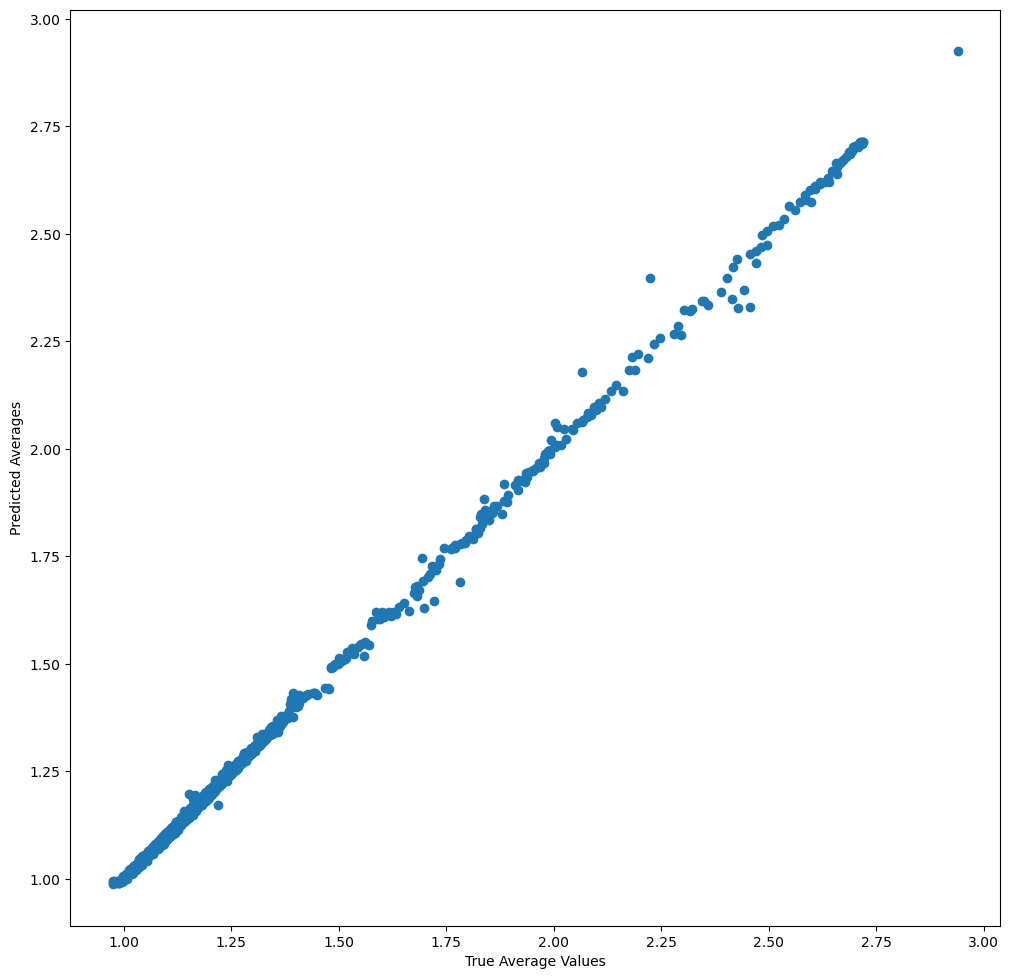

In [93]:
# Calling trained model for predictions:
Y_train_predictions = pd.Series(model.predict(X_train).flatten(),index=X_train.index)
#Visualization of the accuracy:
plt.figure(figsize=(12, 12))
a = plt.axes(aspect='equal')
plt.scatter(y_train, Y_train_predictions)
plt.xlabel('True Average Values')
plt.ylabel('Predicted Averages')
plt.plot()

Text(0, 0.5, 'Count')

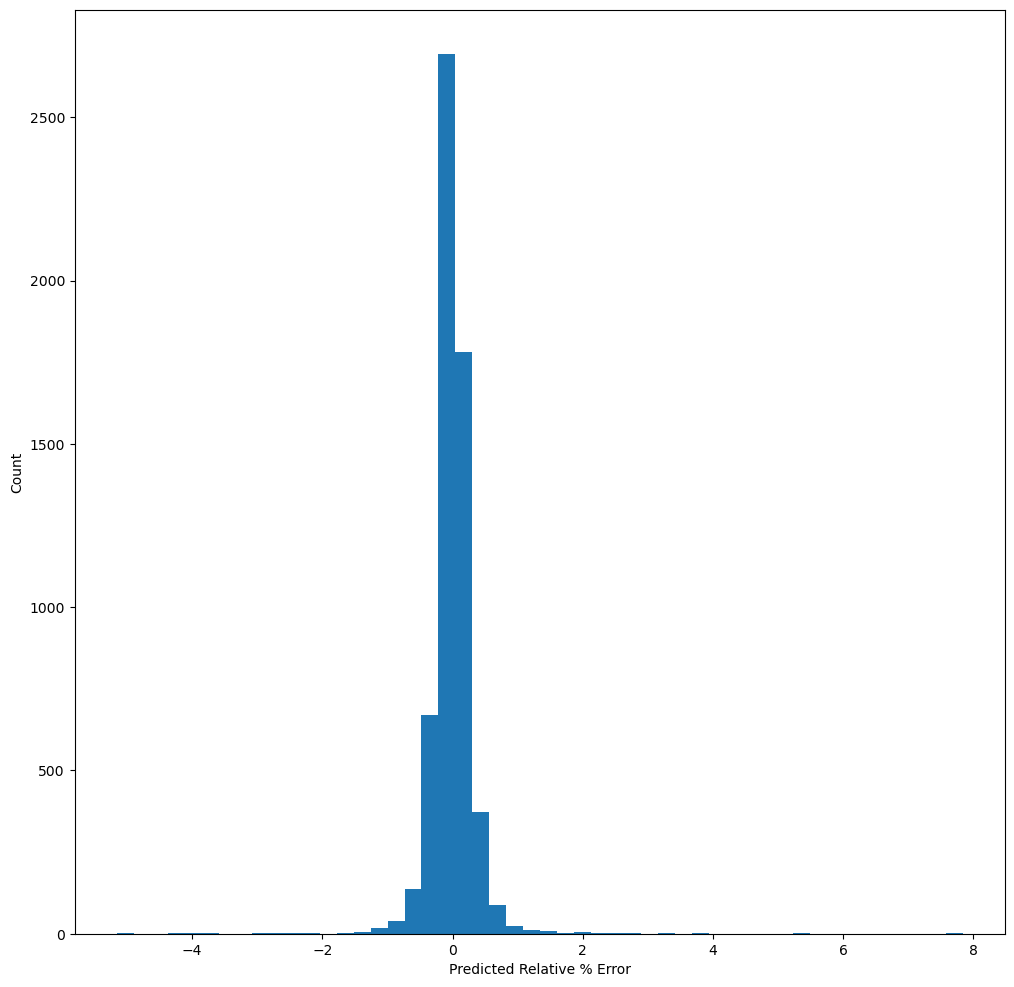

In [94]:
# Calculating the error variations:
error_nn = (Y_train_predictions - y_train['Shear'])/y_train['Shear']*100
plt.figure(figsize=(12, 12))
plt.hist(error_nn, bins=50)
#plt.xlim(-150, 150)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

[]

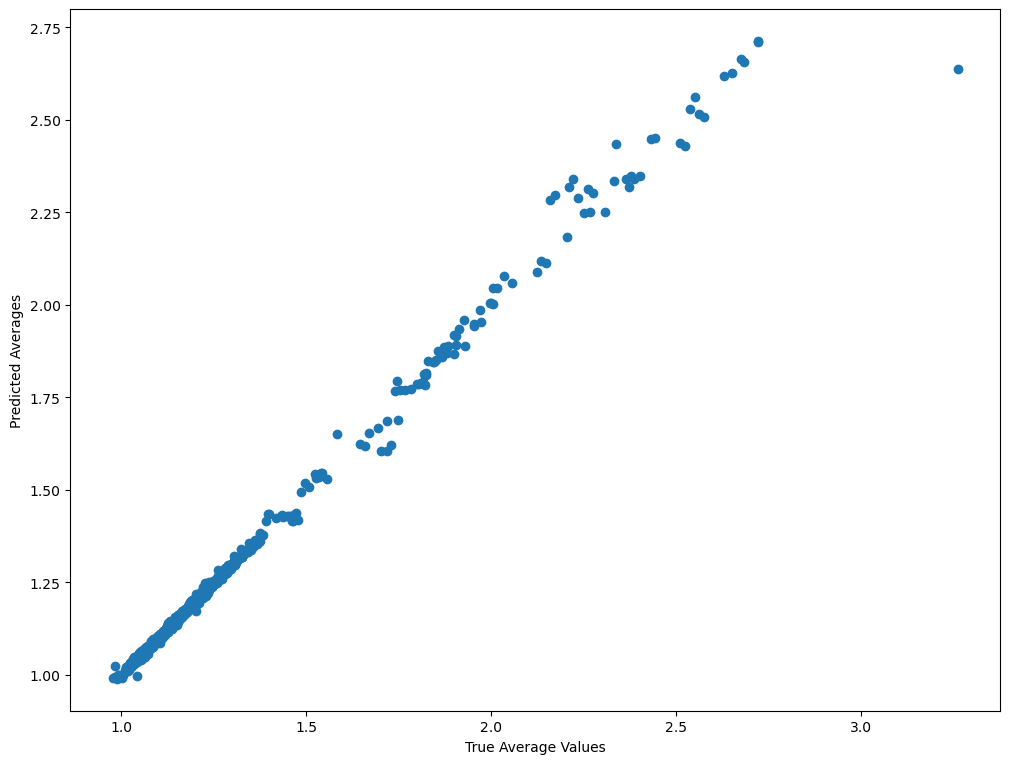

In [95]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
plt.figure(figsize=(12, 12))
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Average Values')
plt.ylabel('Predicted Averages')
plt.savefig('xgboost.png')
plt.plot()

Text(0, 0.5, 'Count')

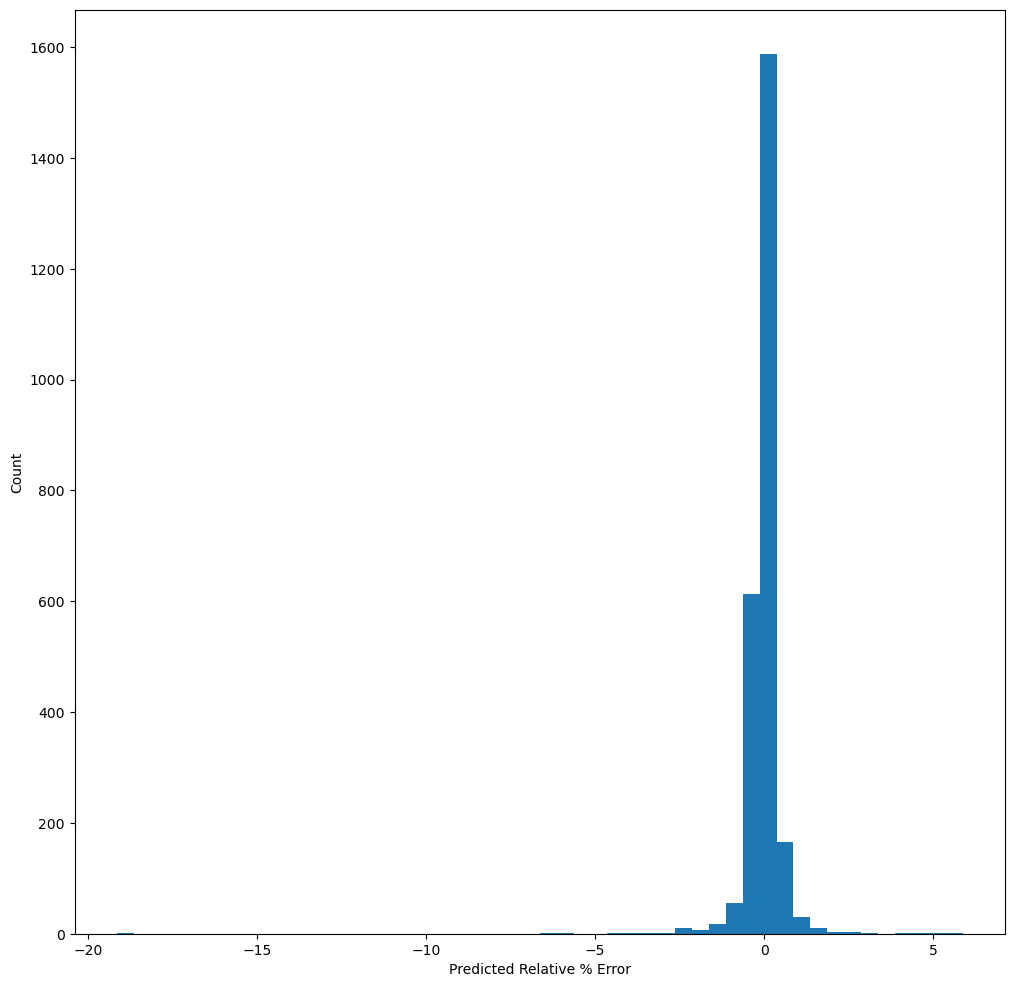

In [96]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test['Shear'])/y_test['Shear']*100
plt.figure(figsize=(12, 12))
plt.hist(error_nn, bins=50)
#plt.xlim(-150, 150)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [97]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test['Shear'])/y_test['Shear']*100
np.average(abs_error_nn)

0.2722989576449946

## RF

In [81]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
n_estimators = 100

#Setting the model:
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)

In [85]:
# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

####Modified###
model = rf

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.values.ravel()):

    #'iloc' can be used when the user doesn’t know the index label:
    #Here we are filtering the data based on indices. Data is divided as 902/225.
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

    #Fitting the model according to given data:
    #Note that model refers to Lasso.
    model.fit(X_train_fold, y_train_fold)

    #Lets check how good is the fitting.
    #'score' returns the coefficient of determination R^2 of the prediction. It is defined as (1 - u/v), 
    # where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
    #The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
  
    # We will first look in the training dataset:
    scoreTraining = model.score(X_train_fold, y_train_fold)
    #Saving our analysis on the list:
    trainingScores.append(scoreTraining)

    #Lets see how good it is on CV dataset:
    scoreCV = model.score(X_cv_fold, y_cv_fold)
    #Saving our analysis on the list:
    cvScores.append(scoreCV)

    #printing the results:
    print('Training Score: ', scoreTraining)
    print('CV Score: ', scoreCV)

#Lets see the overall score for the entire training set (1127)

####Modified###
scoreRF = model.score(X_train,y_train)
print('-----------------------------------')
print('RF Regression Score: ', scoreRF)
print('-----------------------------------')

C:\Users\abood\AppData\Local\Temp\ipykernel_27964\3217225761.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_fold, y_train_fold)


Training Score:  0.999782116453474
CV Score:  0.9958702818038679


C:\Users\abood\AppData\Local\Temp\ipykernel_27964\3217225761.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_fold, y_train_fold)


Training Score:  0.9996658655094603
CV Score:  0.9986655266749194


C:\Users\abood\AppData\Local\Temp\ipykernel_27964\3217225761.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_fold, y_train_fold)


Training Score:  0.9995842398502246
CV Score:  0.9994863973731617


C:\Users\abood\AppData\Local\Temp\ipykernel_27964\3217225761.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_fold, y_train_fold)


Training Score:  0.999727918518377
CV Score:  0.9969475891040086


C:\Users\abood\AppData\Local\Temp\ipykernel_27964\3217225761.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_fold, y_train_fold)


Training Score:  0.9996753356889717
CV Score:  0.9967181817251758
-----------------------------------
RF Regression Score:  0.9990031251493813
-----------------------------------


[]

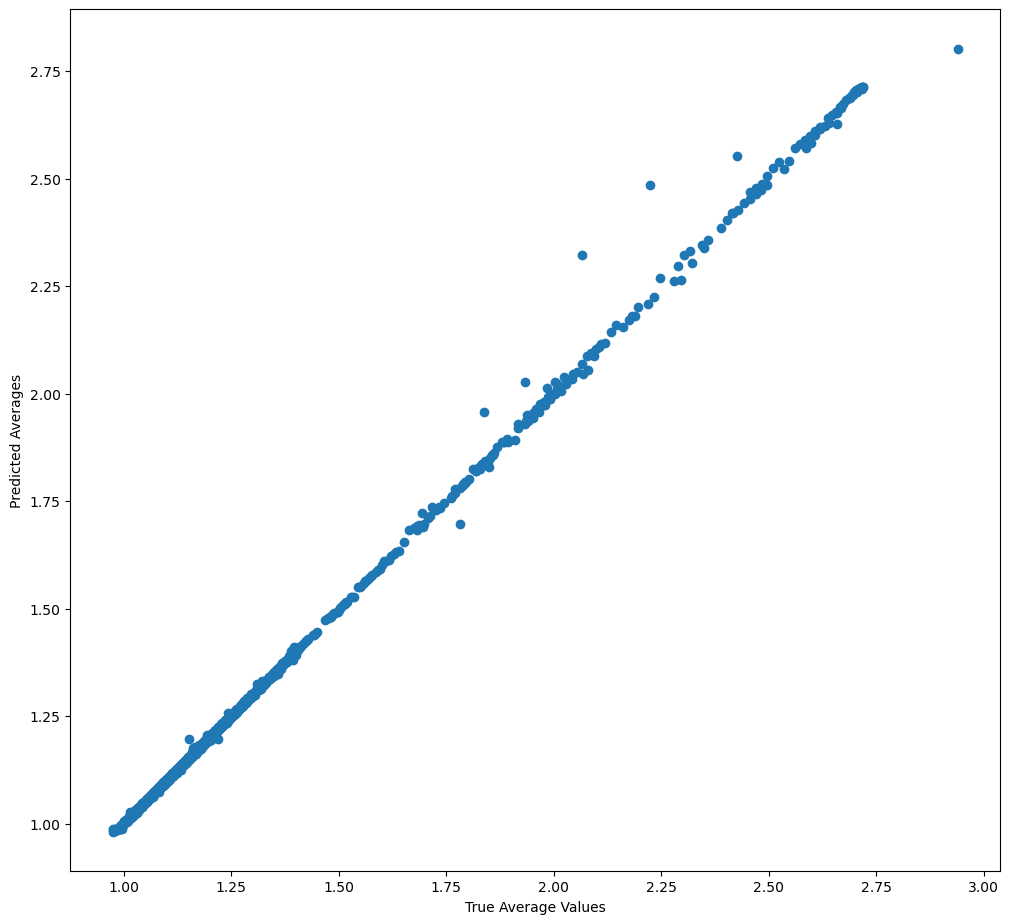

In [87]:
# Calling trained model for predictions:
Y_train_predictions = pd.Series(model.predict(X_train).flatten(),index=X_train.index)
#Visualization of the accuracy:
plt.figure(figsize=(12, 12))
a = plt.axes(aspect='equal')
plt.scatter(y_train, Y_train_predictions)
plt.xlabel('True Average Values')
plt.ylabel('Predicted Averages')
plt.savefig('rfr_train.png')
plt.plot()

Text(0, 0.5, 'Count')

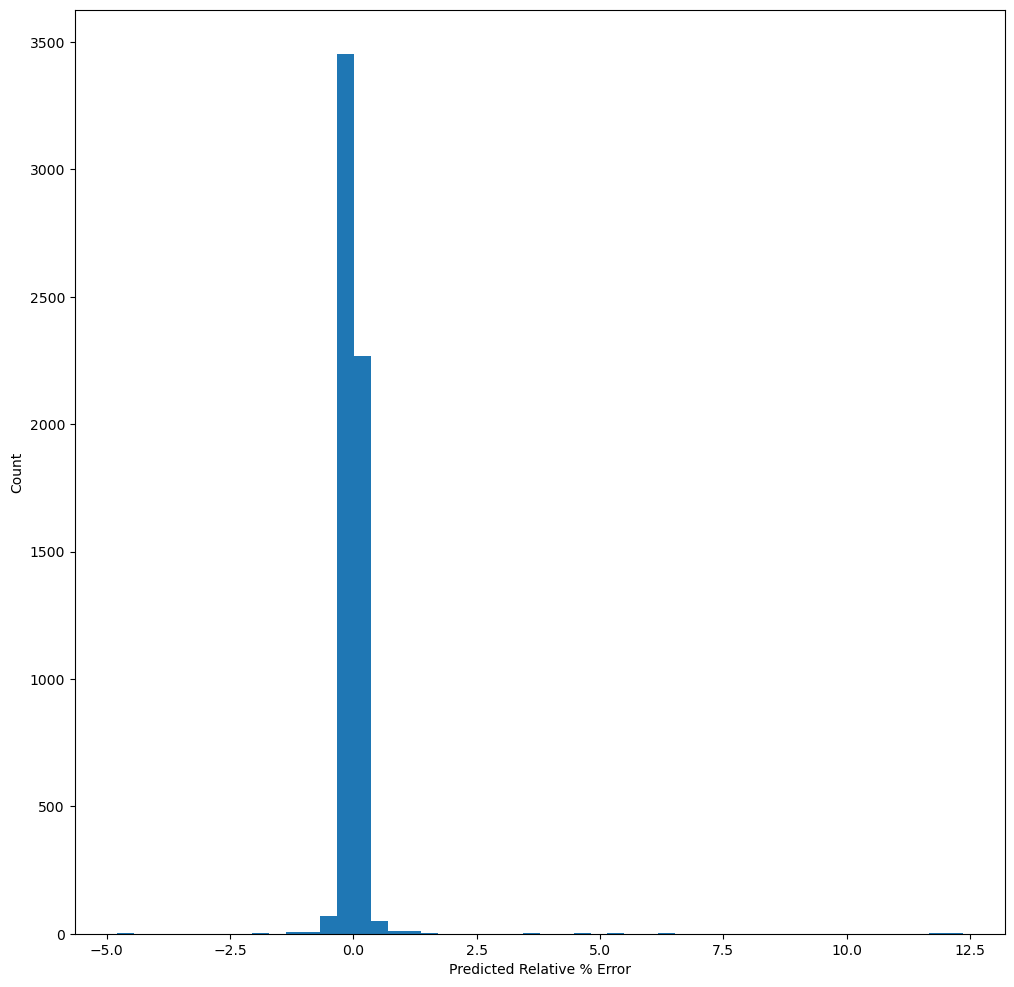

In [88]:
# Calculating the error variations:
error_nn = (Y_train_predictions - y_train['Shear'])/y_train['Shear']*100
#error_nn = (Y_test_predictions - y_test)/y_test*100
plt.figure(figsize=(12, 12))
plt.hist(error_nn, bins=50)
#plt.xlim(-150, 150)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

[]

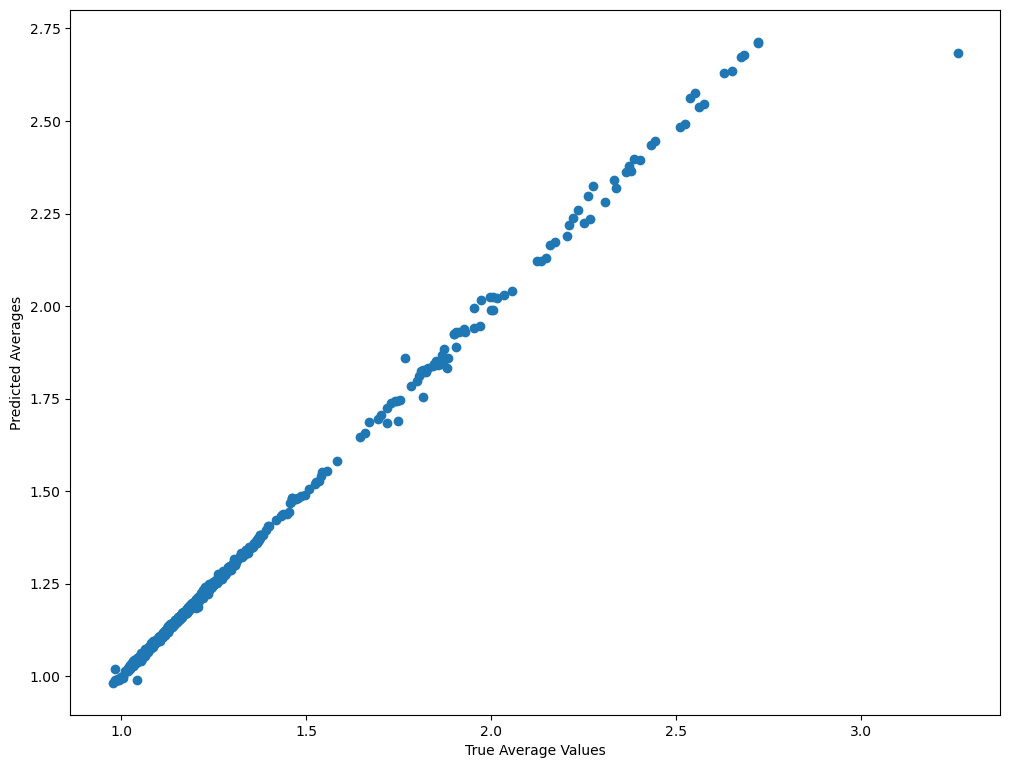

In [89]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
plt.figure(figsize=(12, 12))
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Average Values')
plt.ylabel('Predicted Averages')
plt.savefig('rfr_test.png')
plt.plot()

Text(0, 0.5, 'Count')

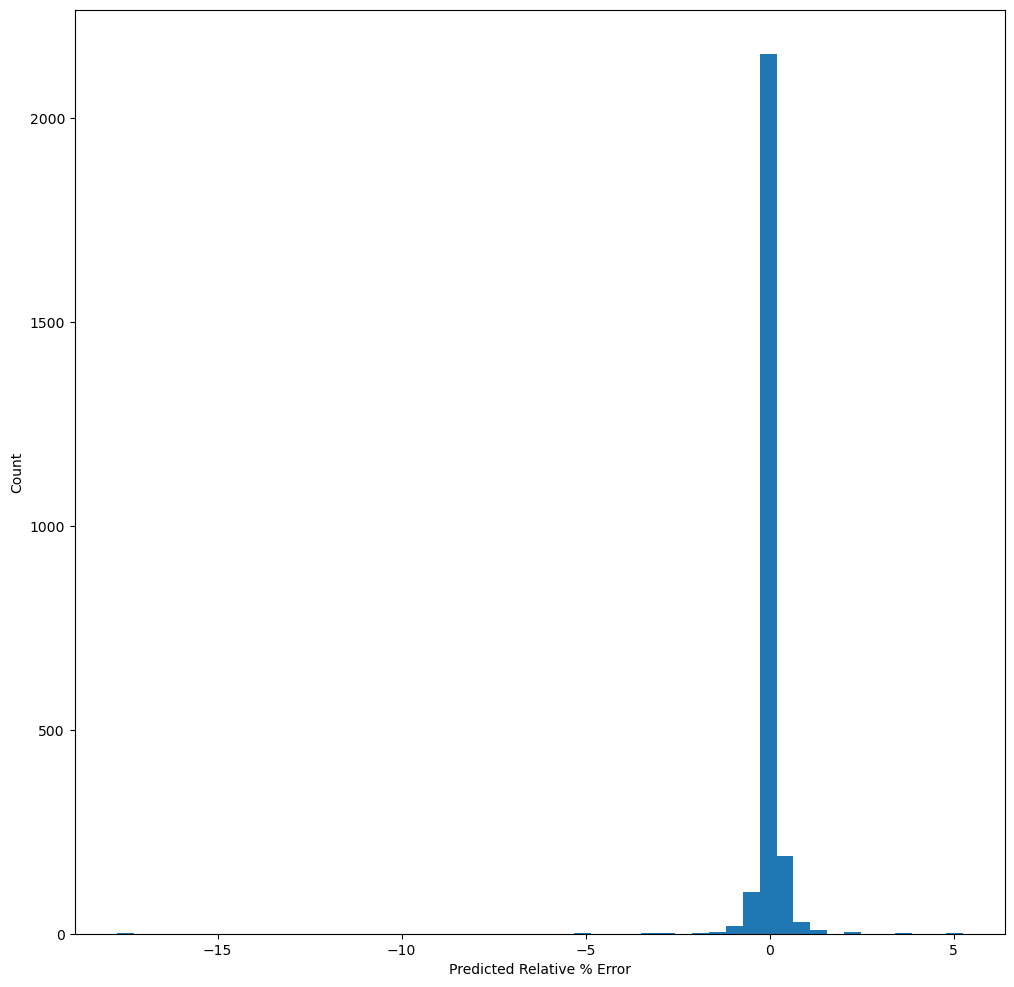

In [90]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test['Shear'])/y_test['Shear']*100
#error_nn = (Y_test_predictions - y_test)/y_test*100
plt.figure(figsize=(12, 12))
plt.hist(error_nn, bins=50)
#plt.xlim(-150, 150)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [91]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test['Shear'])/y_test['Shear']*100
np.average(abs_error_nn)

0.14583583990254714

## ANN

In [39]:
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers

In [41]:
# Lets show it over a similar network:
n_nodes = 5
reg = 0.01
def build_model_batch():
    #Here we will use Sequential API
    model = models.Sequential([
                             
    layers.Dense(n_nodes,  kernel_regularizer=regularizers.l2(reg), activation="relu", kernel_initializer="he_normal", input_shape=(X_train.shape[1],)),                           
    layers.BatchNormalization(),
    layers.Dense(n_nodes,  kernel_regularizer=regularizers.l2(reg), activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dense(n_nodes,  kernel_regularizer=regularizers.l2(reg), activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dense(n_nodes,  kernel_regularizer=regularizers.l2(reg), activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dense(n_nodes,  kernel_regularizer=regularizers.l2(reg), activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dense(n_nodes,  kernel_regularizer=regularizers.l2(reg), activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dense(n_nodes,  kernel_regularizer=regularizers.l2(reg), activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dense(n_nodes,  kernel_regularizer=regularizers.l2(reg), activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dense(n_nodes,  kernel_regularizer=regularizers.l2(reg), activation="relu", kernel_initializer="he_normal"),
    layers.BatchNormalization(),
    layers.Dense(1)
    ])
      
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model

In [212]:
def build_model_batch():
    model = keras.Sequential([
        layers.Dense(3, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(1)
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [213]:
#Looking into model structure:
build_model_batch().summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 3)                 123       
                                                                 
 dense_99 (Dense)            (None, 1)                 4         
                                                                 
Total params: 127 (508.00 Byte)
Trainable params: 127 (508.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [214]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("my_best_model.h5", save_best_only=True)

In [215]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

In [216]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 1000
batch_size = 10

In [217]:
#......................................
# k-fold implementation:
#......................................

# Model Training:
#-----------------------------------------------------------------------------

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.values.ravel()):

    #'iloc' can be used when the user doesn’t know the index label:
    #Here we are filtering the data based on indices. Data is divided as 902/225.
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

    #Fitting the model according to given data:
    #Into the fit method, we will pass in the input matrix X and the target y (labels).

    #Building the Keras models:
    model_base = build_model_batch()

    #Training step: Trains the model in silent mode (verbose = 0)
    ##----------Changed!----------##
    # Training and CV scores will be saved by the model on the history:
    history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) , 
                                  callbacks=[myCheckpoint,myEarly_stopping], verbose=0)
    break
#Calling back the best model:
model_best = keras.models.load_model("my_best_model.h5")

C:\Users\abood\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/184 [==============================] - 0s 703us/step


[]

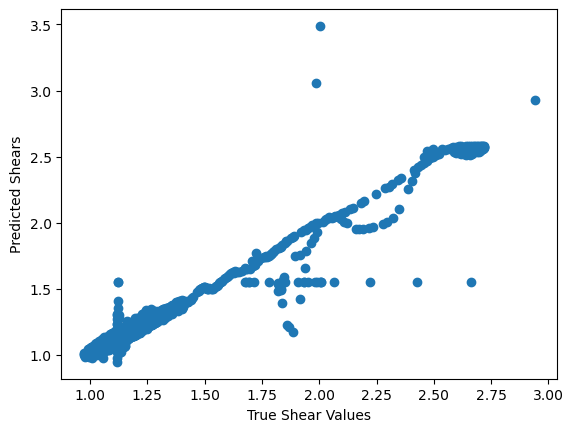

In [218]:
# Calling trained model for predictions:
Y_train_predictions = pd.Series(model_best.predict(X_train).flatten(),index=X_train.index)
#Visualization of the accuracy:
#a = plt.axes(aspect='equal')
#plt.ylim(-2, 2)
plt.scatter(y_train, Y_train_predictions)
plt.xlabel('True Shear Values')
plt.ylabel('Predicted Shears')
plt.plot()

Text(0, 0.5, 'Count')

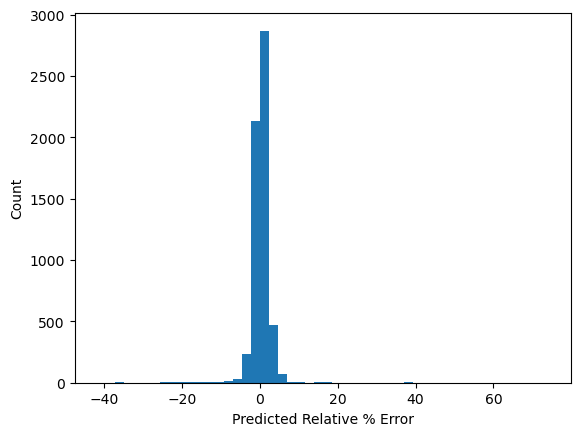

In [219]:
# Calculating the error variations:
error_nn = (Y_train_predictions - y_train['Shear'])/y_train['Shear']*100
plt.hist(error_nn, bins=50)
#plt.xlim(-150, 150)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [220]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_train_predictions - y_train['Shear'])/y_train['Shear']*100
np.average(abs_error_nn)

1.4467879868544897

79/79 [==============================] - 0s 629us/step


[]

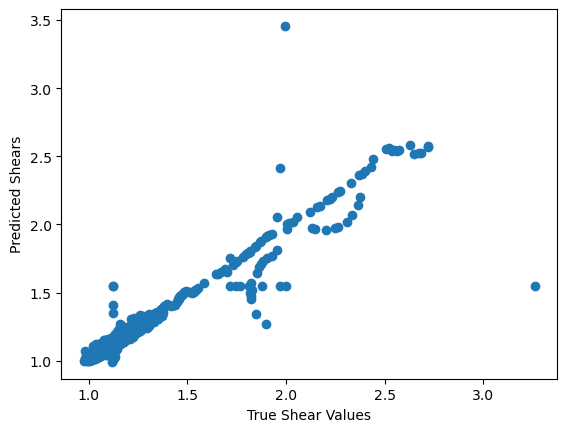

In [221]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_best.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
#a = plt.axes(aspect='equal')
#plt.ylim(-2, 2)
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Shear Values')
plt.ylabel('Predicted Shears')
plt.savefig('ann.png')
plt.plot()

In [222]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test['Shear'])/y_test['Shear']*100
np.average(abs_error_nn)

1.4667909376692216